<a href="https://colab.research.google.com/github/michael-sam/data_analytics/blob/main/eda/eda_general_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction

There are many ways to perform EDA. This notebook layouts some general approaches and overall structure for EDA that can be useful for future reference. 

We will use this [dataset](https://www.kaggle.com/gauthamp10/google-playstore-apps) comprises more than 1 million apps on the Google Play Store. 

This notebook attempts to compare the performance of free and paid apps in the top 8 most popular app categories on Google Play Store (excluding games):
- Education
- Business
- Music & Audio
- Tools
- Entertainment
- Lifestyle
- Books & Reference
- Food & Drink

## 1.1 Setup

Install additional libraries: `empiricaldist`, `missingno` and `colorama`:

In [ ]:
!pip install empiricaldist

In [ ]:
!pip install missingno

In [ ]:
!pip install colorama

In [ ]:
# Base libraries
import time
import datetime
import os

# Scientific libraries
import numpy as np
import pandas as pd
from empiricaldist import Cdf, Pmf

# Visual libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import missingno as msno  # Visualize missing values

# Helper libraries
from tqdm.notebook import tqdm, trange
from colorama import Fore, Back, Style
import warnings
warnings.filterwarnings('ignore')

# Visual setup
import matplotlib.ticker as ticker
plt.style.use('ggplot')
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['figure.figsize'] = [12, 9]
rcParams['font.size'] = 16
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
custom_colors = ['#74a09e','#86c1b2','#98e2c6','#f3c969','#f2a553', '#d96548', '#c14953']
sns.set_palette(custom_colors)
%config InlineBackend.figure_format = 'retina'
%config Completer.use_jedi = False

# Pandas options
pd.set_option('max_colwidth', 40)
pd.options.display.max_columns = None  # Possible to limit
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Seed value for numpy.random
np.random.seed(42)

Load the data:

Download dataset (~300MB): [Google Drive download link](https://drive.google.com/file/d/1yaNRTm04XpxQm8XRjDYh_IV2WlJ5stL5/view?usp=sharing) 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
apps = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/github/eda/dataset/Google-Playstore.csv')
apps.head()

App Name                    App Id  \
0                   HTTrack Website Copier       com.httrack.android   
1            World War 2: Offline Strategy           com.skizze.wwii   
2                                   WPSApp     com.themausoft.wpsapp   
3  OfficeSuite - Office, PDF, Word, Exc...    com.mobisystems.office   
4                         Loud Player Free  com.arthelion.loudplayer   

        Category  Rating  Rating Count      Installs  Minimum Installs  \
0  Communication     3.6        2848.0      100,000+          100000.0   
1       Strategy     4.3       17297.0    1,000,000+         1000000.0   
2          Tools     4.2      488639.0   50,000,000+        50000000.0   
3       Business     4.2     1224420.0  100,000,000+       100000000.0   
4  Music & Audio     4.2         665.0       50,000+           50000.0   

   Maximum Installs  Free  Price Currency  Size Minimum Android  Developer Id  \
0            351560  True    0.0      USD  2.7M      2.3 and up  Xavier Roche   
1           2161778  True    0.0      USD   86M      5.1 and up  Skizze Games   
2          79304739  True    0.0      USD  5.8M      4.1 and up    TheMauSoft   
3         163660067  True    0.0      USD   59M      4.4 and up   MobiSystems   
4             73463  True    0.0      USD   29M      5.0 and up   Arthelion92   

            Developer Website                          Developer Email  \
0     http://www.httrack.com/                roche+android@httrack.com   
1         http://stereo7.com/                   Skizze.Games@gmail.com   
2   http://www.themausoft.com                     wpsapp.app@gmail.com   
3  http://www.mobisystems.com  support-officesuite-android@mobisyst...   
4    http://www.arthelion.com                    arthelion92@gmail.com   

       Released  Last Updated Content Rating  \
0  Aug 12, 2013  May 20, 2017       Everyone   
1  Jul 19, 2018  Nov 26, 2020   Everyone 10+   
2   Mar 7, 2016  Oct 21, 2020       Everyone   
3  Dec 22, 2011  Nov 23, 2020       Everyone   
4  Sep 24, 2016  Nov 22, 2020       Everyone   

                            Privacy Policy  Ad Supported  In App Purchases  \
0  http://android.httrack.com/privacy-p...         False             False   
1  https://www.iubenda.com/privacy-poli...          True              True   
2  https://sites.google.com/view/wpsapp...          True             False   
3  http://www.mobisystems.com/mobile/pr...          True              True   
4  http://www.arthelion.com/index.php/f...         False             False   

   Editors Choice  
0           False  
1           False  
2           False  
3           False  
4           False

# 2. Basic Exploration and Data Cleaning

## 2.1 Basic Exploration

Start with basic exploration of the dataset.

In [ ]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118136 entries, 0 to 1118135
Data columns (total 23 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   App Name           1118135 non-null  object 
 1   App Id             1118136 non-null  object 
 2   Category           1118133 non-null  object 
 3   Rating             1111286 non-null  float64
 4   Rating Count       1111286 non-null  float64
 5   Installs           1117975 non-null  object 
 6   Minimum Installs   1117975 non-null  float64
 7   Maximum Installs   1118136 non-null  int64  
 8   Free               1118136 non-null  bool   
 9   Price              1118136 non-null  float64
 10  Currency           1117975 non-null  object 
 11  Size               1118136 non-null  object 
 12  Minimum Android    1116123 non-null  object 
 13  Developer Id       1118134 non-null  object 
 14  Developer Website  703770 non-null   object 
 15  Developer Email    1118114 non-n

There are 23 columns and several of them have missing values. 

In [ ]:
apps.isnull().sum()

App Name                  1
App Id                    0
Category                  3
Rating                 6850
Rating Count           6850
Installs                161
Minimum Installs        161
Maximum Installs          0
Free                      0
Price                     0
Currency                161
Size                      0
Minimum Android        2013
Developer Id              2
Developer Website    414366
Developer Email          22
Released               7730
Last Updated              0
Content Rating            0
Privacy Policy       153524
Ad Supported              0
In App Purchases          0
Editors Choice            0
dtype: int64

To change the columns of dataset to *snake_case* because it will be easier to choose them later on (added to the list).

Columns that will not be useful: App ID, minimum and maximum installs, minimum android version, developer ID, website and email, privacy policy link, scraped time.

In [ ]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118136 entries, 0 to 1118135
Data columns (total 23 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   App Name           1118135 non-null  object 
 1   App Id             1118136 non-null  object 
 2   Category           1118133 non-null  object 
 3   Rating             1111286 non-null  float64
 4   Rating Count       1111286 non-null  float64
 5   Installs           1117975 non-null  object 
 6   Minimum Installs   1117975 non-null  float64
 7   Maximum Installs   1118136 non-null  int64  
 8   Free               1118136 non-null  bool   
 9   Price              1118136 non-null  float64
 10  Currency           1117975 non-null  object 
 11  Size               1118136 non-null  object 
 12  Minimum Android    1116123 non-null  object 
 13  Developer Id       1118134 non-null  object 
 14  Developer Website  703770 non-null   object 
 15  Developer Email    1118114 non-n

Some columns have incorrect data types: Released, Size. Released should be a `datetime`. Size is probably rendered as string because each size contains the letter 'M' to indicate megabytes.

App categories:

In [ ]:
apps['Category'].value_counts()

Education                  115242
Music & Audio              104541
Entertainment               82079
Books & Reference           78969
Personalization             73538
Tools                       68953
Lifestyle                   54586
Business                    42210
Health & Fitness            31532
Productivity                30450
Photography                 28942
Travel & Local              25971
Puzzle                      24954
Finance                     24846
Food & Drink                24250
Sports                      22094
News & Magazines            21553
Casual                      20509
Shopping                    20440
Communication               18391
Arcade                      17715
Social                      16987
Simulation                  15372
Action                      12628
Medical                     12554
Art & Design                12322
Educational                 11351
Maps & Navigation           10468
Adventure                   10124
Video Players 

Some categories of interest like Music and Eduction are given with different labels: there are both 'Music & Audio' and 'Music' labels as well as 'Education' and 'Educational' for education. They should be merged together to represent a single category. 

Numerical features of the dataset:

In [ ]:
# Display in normal notation instead of scientific
with pd.option_context('float_format', '{:f}'.format):
    apps.describe()

Rating     Rating Count   Minimum Installs   Maximum Installs  \
count 1111286.000000   1111286.000000     1117975.000000     1118136.000000   
mean        2.490334      5159.633249      313643.231397      544453.372541   
std         2.053973    272409.445111    20439406.353971    30310580.652221   
min         0.000000         0.000000           0.000000           0.000000   
25%         0.000000         0.000000         100.000000         160.000000   
50%         3.600000        11.000000        1000.000000        1719.000000   
75%         4.300000       100.000000       10000.000000       19116.000000   
max         5.000000 125380770.000000 10000000000.000000 10772700105.000000   

               Price  
count 1118136.000000  
mean        0.205073  
std         3.541011  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max       400.000000

Looks like all numerical columns are within the sensible range, like rating should be between 0 and 5. But the maximum value for price is $400 which is odd.

### Issues List For the Dataset
- Missing values in several cols: rating, rating count, installs, minimum and maximum installs, currency and more
- Convert all columns to snake_case
- Drop these columns: app ID, minimum android version, developer ID, website, email, privacy policy link.
- Incorrect data types for release data and size
- Music and Education is represented by different labels
- Drop unnecessary categories

## 2.2 Data Cleaning

### Convert all columns to snake case

In [ ]:
apps.rename(lambda x: x.lower().strip().replace(' ', '_'), 
            axis='columns', inplace=True)

Check the results:

In [ ]:
apps.columns

Index(['app_name', 'app_id', 'category', 'rating', 'rating_count', 'installs',
       'minimum_installs', 'maximum_installs', 'free', 'price', 'currency',
       'size', 'minimum_android', 'developer_id', 'developer_website',
       'developer_email', 'released', 'last_updated', 'content_rating',
       'privacy_policy', 'ad_supported', 'in_app_purchases', 'editors_choice'],
      dtype='object')

### Drop unnecessary columns

In [ ]:
# Specify the cols to drop

to_drop = [
    'app_id', 'minimum_android', 
    'developer_id', 'developer_website', 'developer_email', 'privacy_policy', 
    'ad_supported', 'in_app_purchases', 'editors_choice'
]

# Drop them
apps.drop(to_drop, axis='columns', inplace=True)

Check:

In [ ]:
assert apps.columns.all() not in to_drop

### Collapse multiple categories into one

In [ ]:
# Collapse 'Music' and 'Music & Audio' into 'Music'
apps['category'] = apps['category'].str.replace('Music & Audio', 'Music')

In [ ]:
# Collapse 'Educational' and 'Education' into 'Education'
apps['category'] = apps['category'].str.replace('Educational', 'Education')

Check:

In [ ]:
assert 'Educational' not in apps['category'] and \
       'Music & Audio' not in apps['category']

### Subset only for top 8 categories

In [ ]:
top_8_list = [
    'Education', 'Music', 'Business', 'Tools', 
    'Entertainment', 'Lifestyle', 'Food & Drink', 
    'Books & Reference'
]

top = apps[apps['category'].isin(top_8_list)].reset_index(drop=True)

Check:

In [ ]:
assert top['category'].all() in top_8_list

### Convert `released` to `datetime`

In [ ]:
# Specifying the datetime format significantly reduces conversion time
top['released'] = pd.to_datetime(top['released'], format='%b %d, %Y',
                                 infer_datetime_format=True, errors='coerce')

Check:

In [ ]:
top.released.dtype

dtype('<M8[ns]')

### Convert `size` to float

In [ ]:
# Strip of all text and convert to numeric
top['size'] = pd.to_numeric(top['size'].str.replace(r'[a-zA-Z]+', ''), 
                             errors='coerce')

Check:

In [ ]:
assert top['size'].dtype == 'float64'

### Deal With Missing Values

There seems to be much more missing values in `size`, well over the threshold where we can safely drop them. We can dive deeper using the `missingno` package:

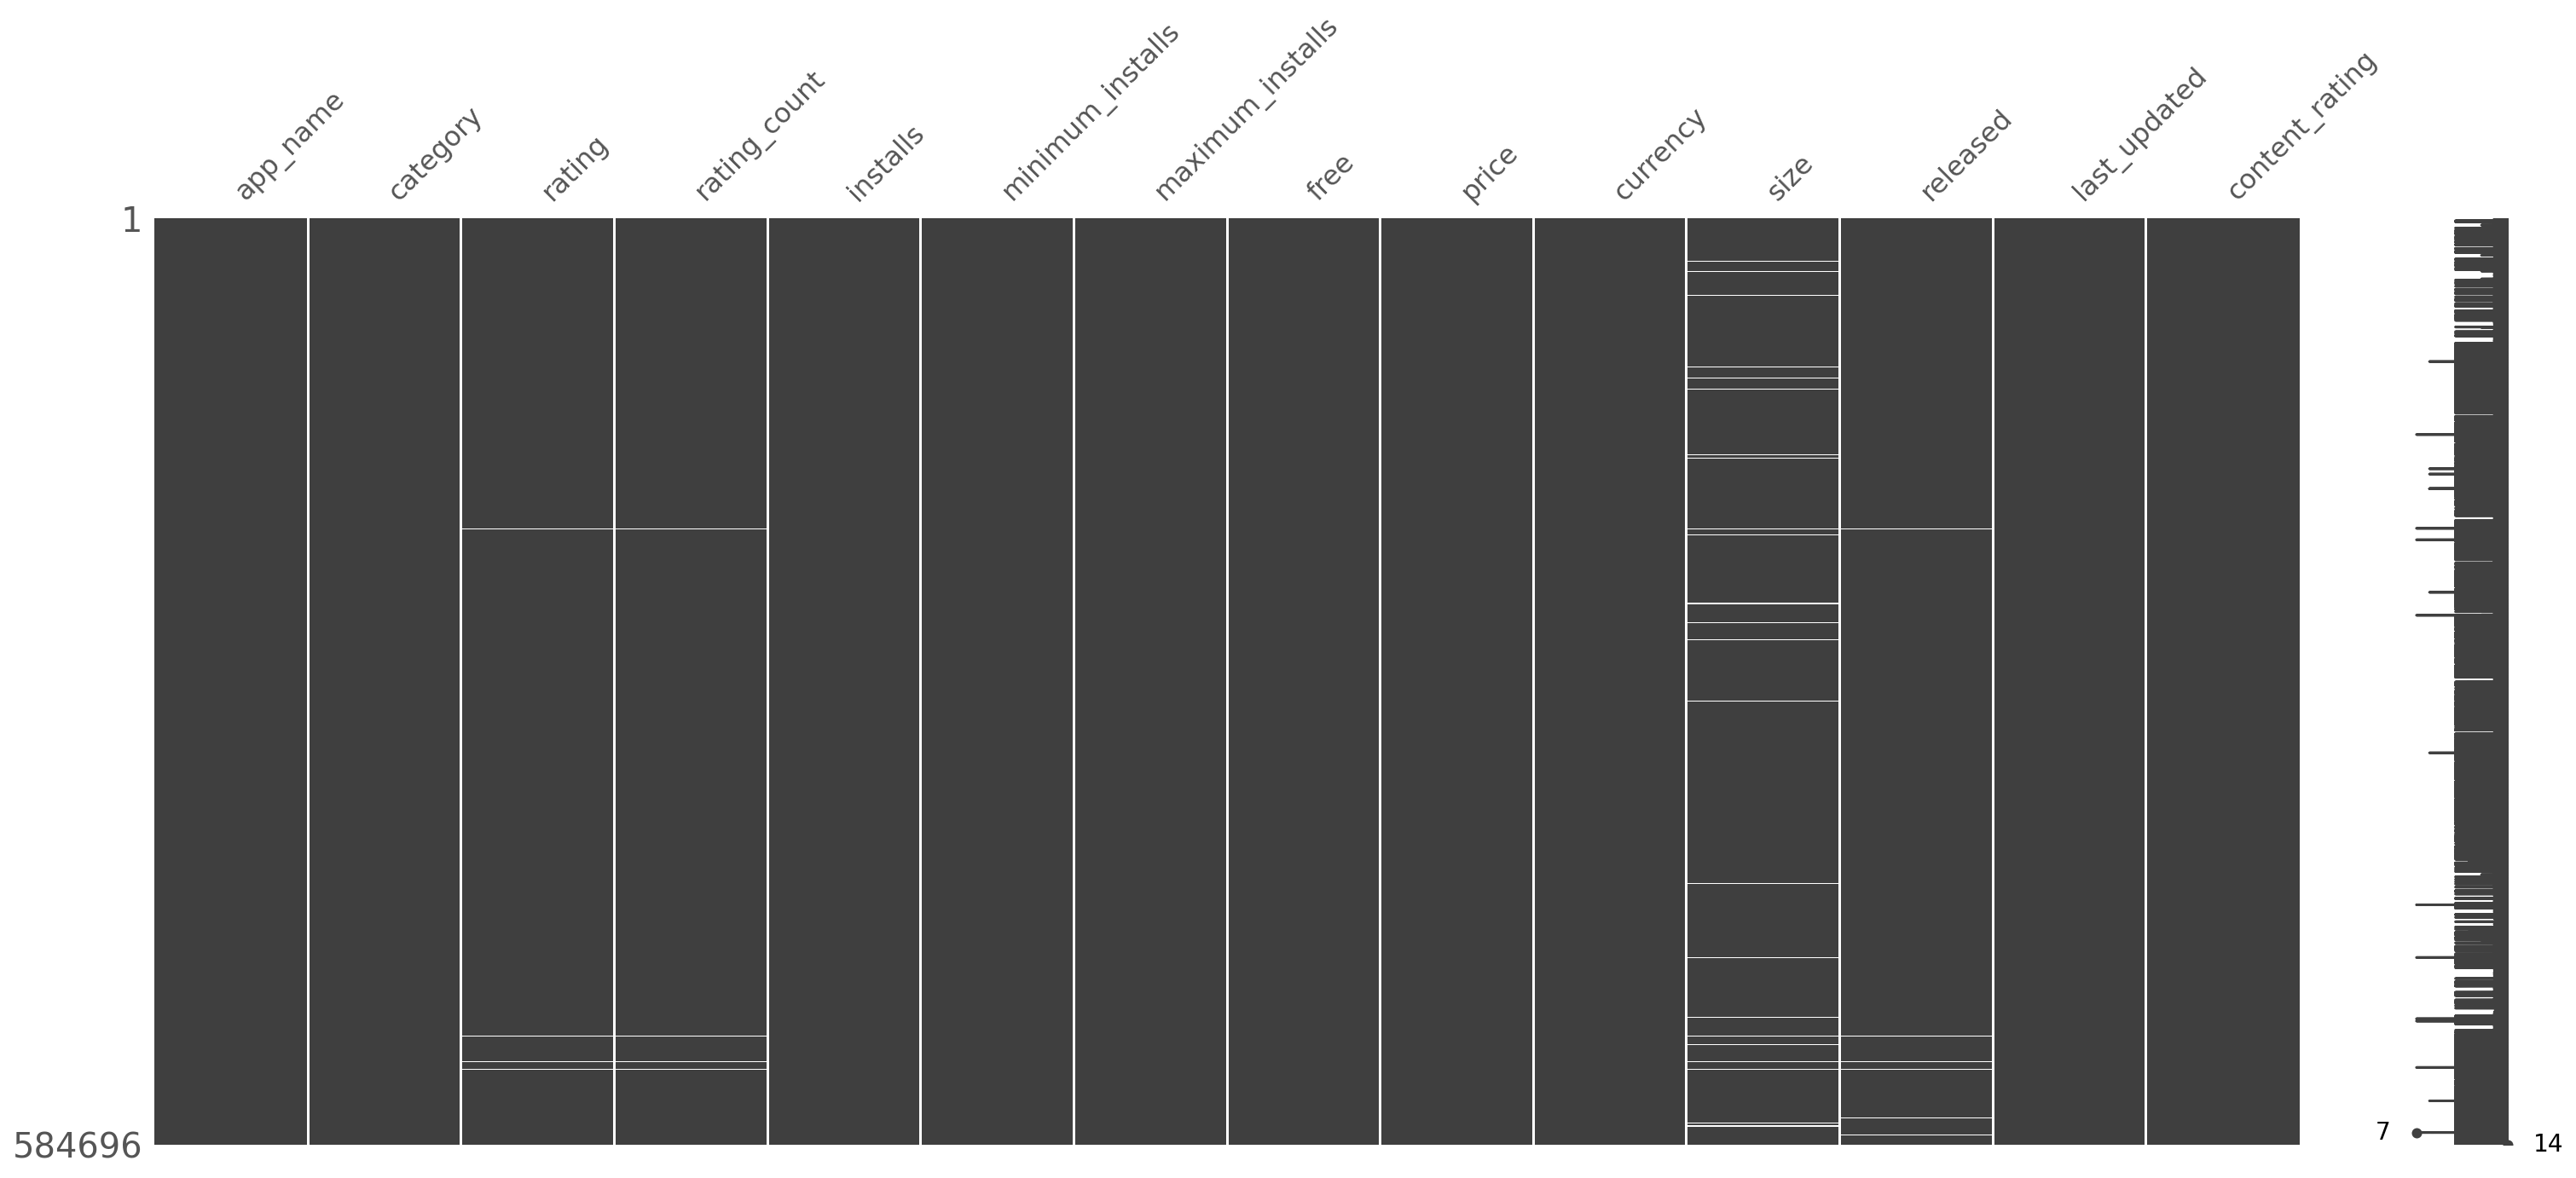

In [ ]:
msno.matrix(top.sort_values('category'));

Plotting the data sorted by category tells that nulls in `size` are randomly scattered. We can plot the missingness correlation:

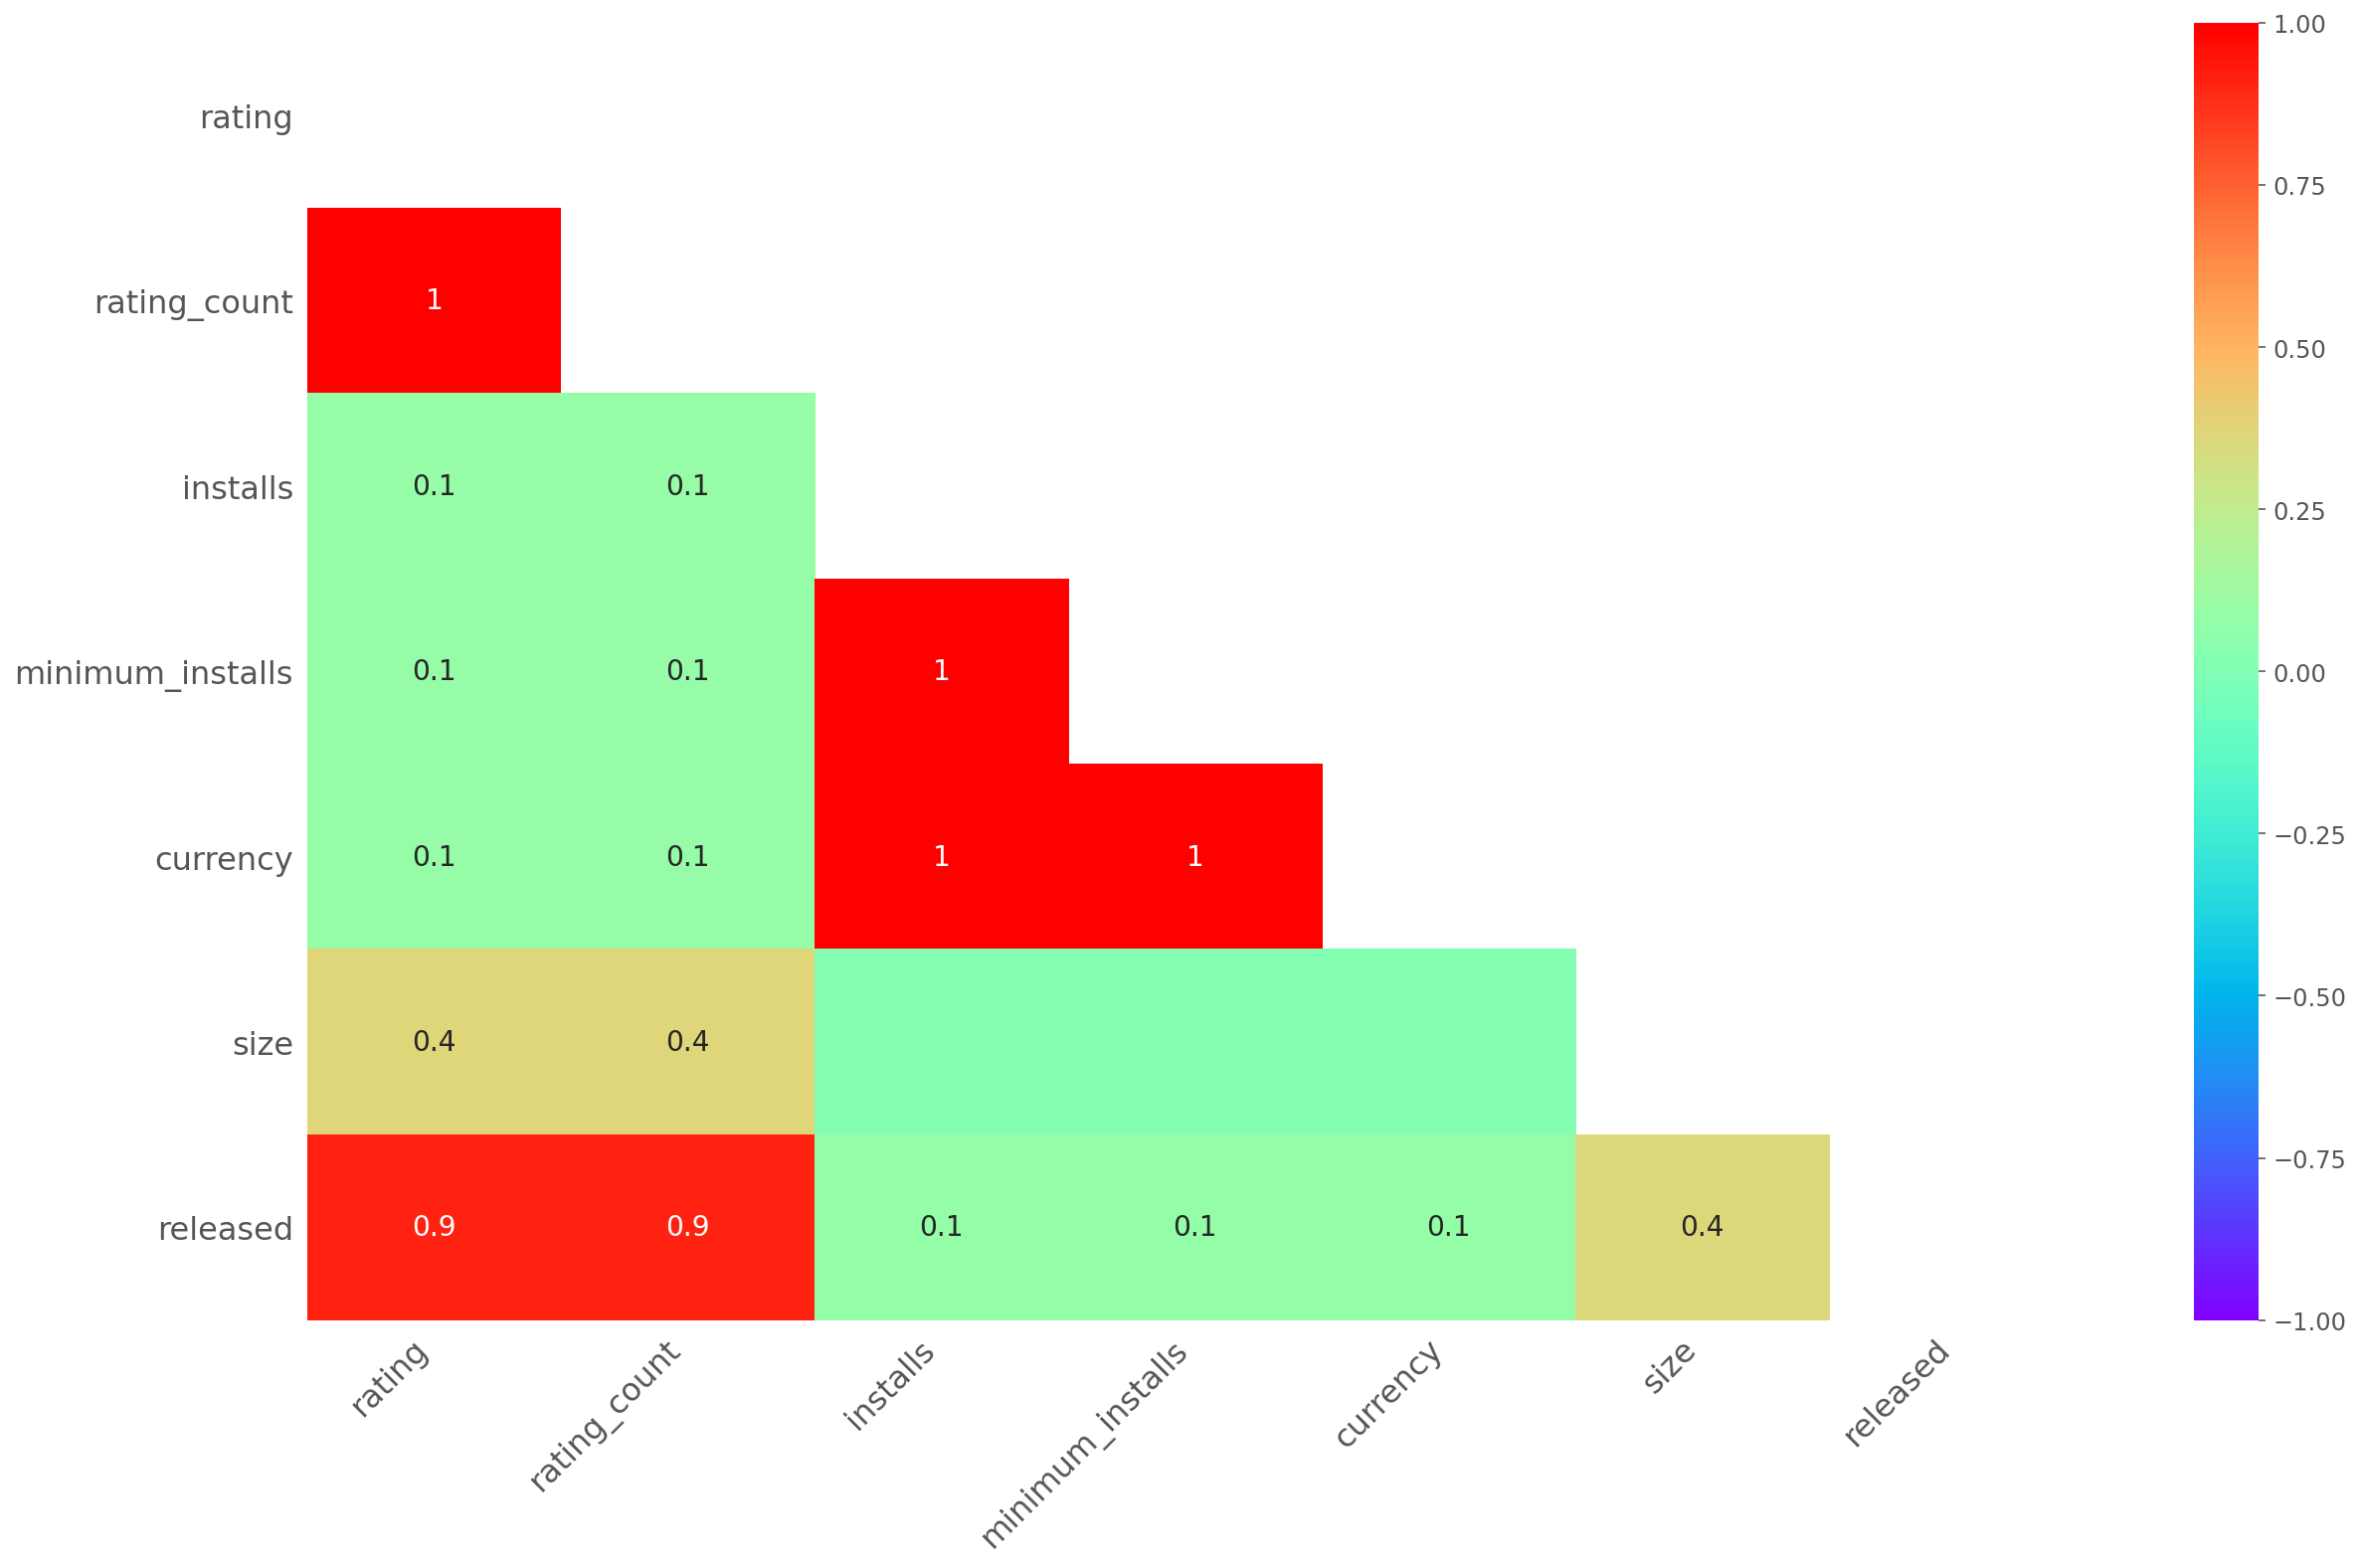

In [ ]:
msno.heatmap(top, cmap='rainbow');

The correlation matrix of missingness shows that most nulls in `size` are associated with nulls in `rating` and `rating_count`. This scenario falls into the Missing At Random class of missingness. This means that even though null values are random their misssingness is related to other observed values. 

In most cases, we can impute them with ML techniques. But our case is specific because we don't have enough features that help predict the size or rating of an app. We have no choice but to drop them. Nulls in other columns are less concerning because their proportion is marginal.

In [ ]:
top.dropna(inplace=True)

# 3. Univariate Exploration

Visualizing distribution of the numerical features of the dataset, starting with rating:

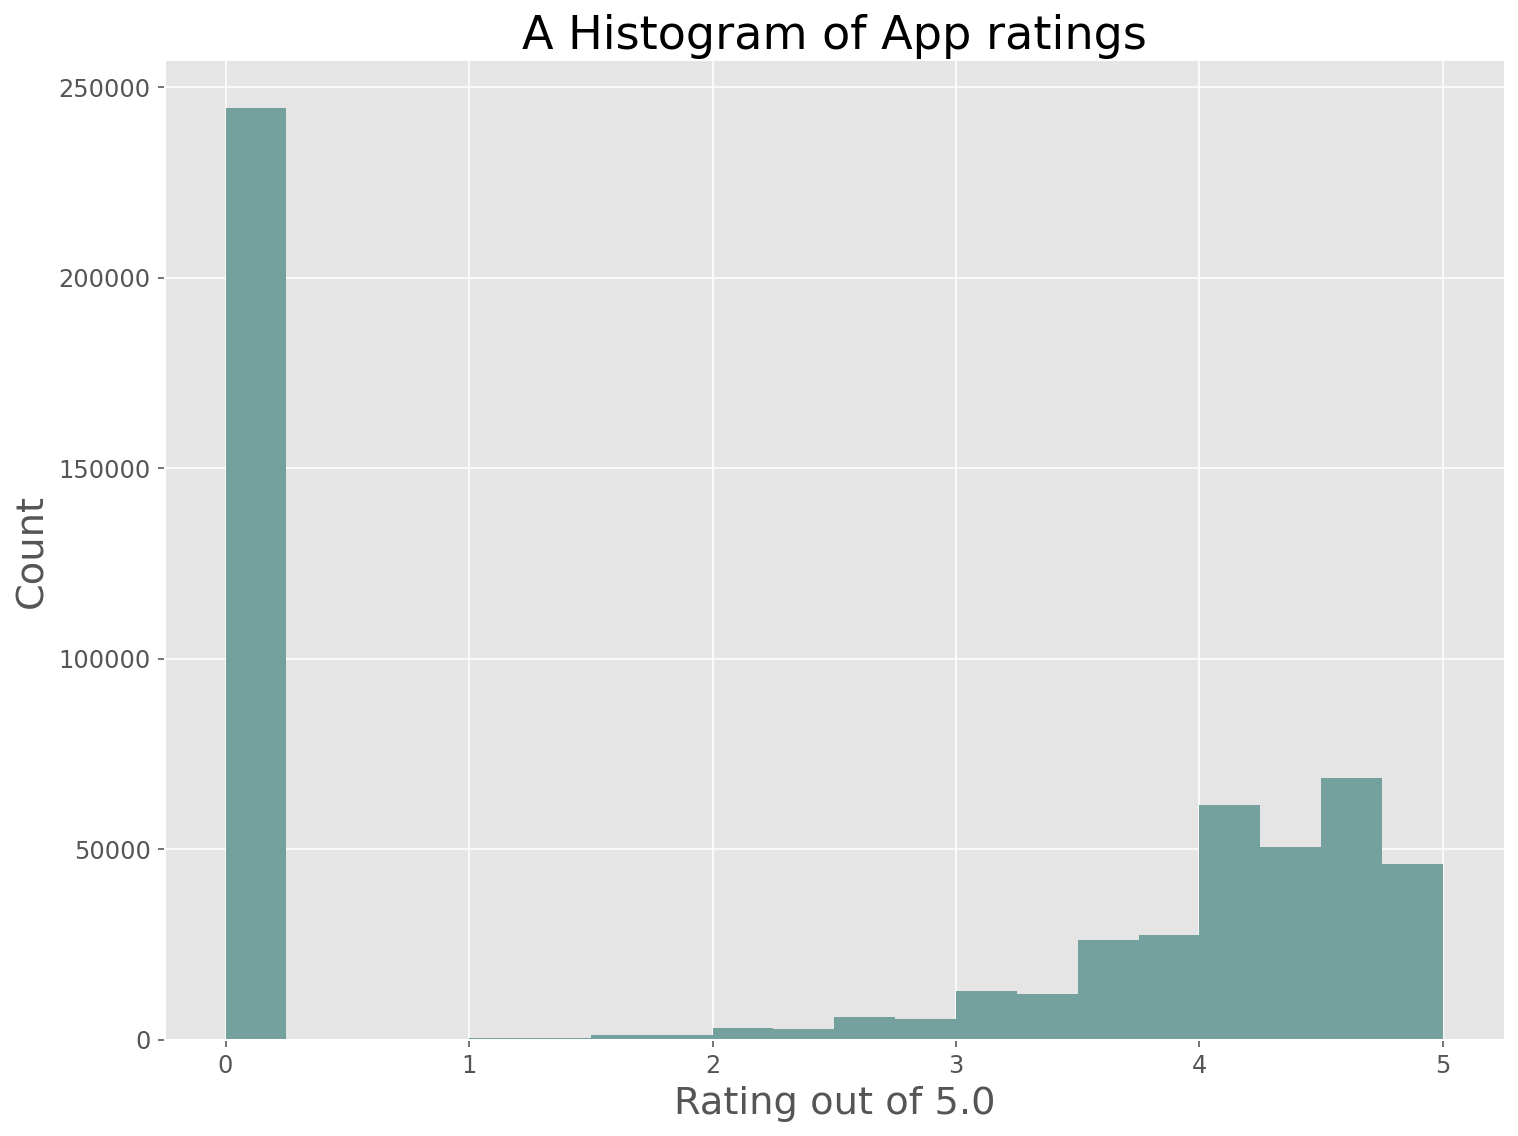

In [ ]:
fig, ax = plt.subplots()

# Plot a histogram
ax.hist(top['rating'], bins=20)
# Label
ax.set(title='A Histogram of App ratings',
       xlabel='Rating out of 5.0',
       ylabel='Count')
plt.show();

There are a lot of apps with no rating. We might get a better visual if omit them:

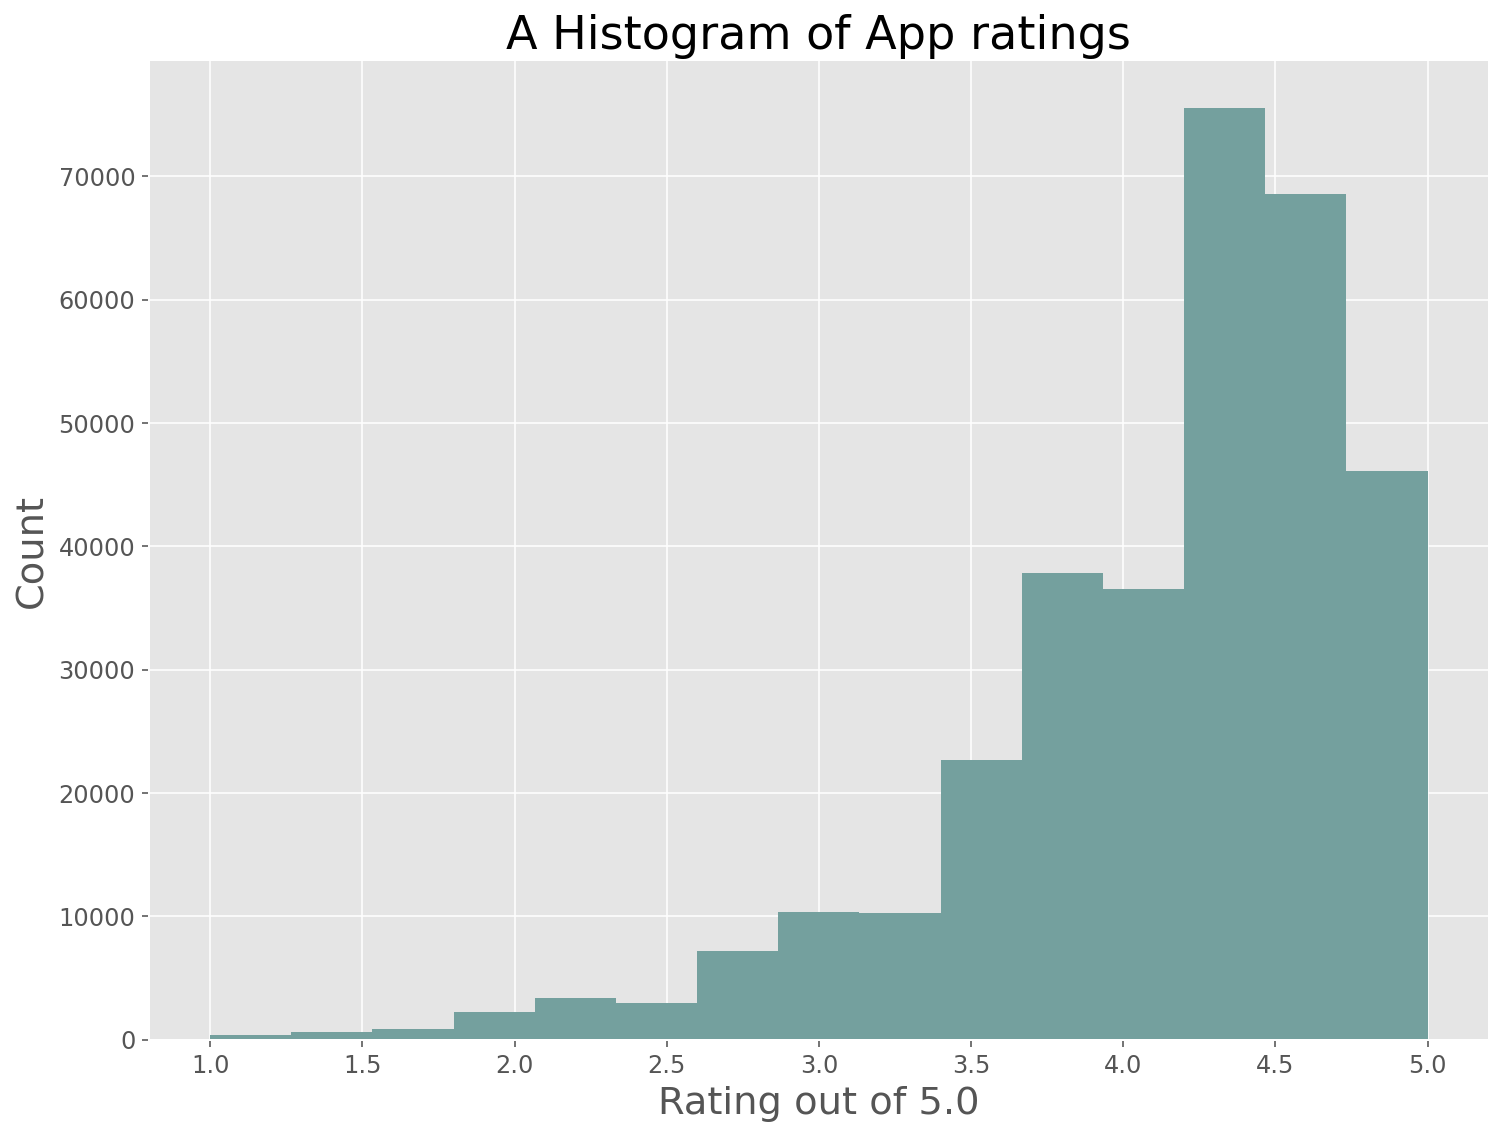

In [ ]:
fig, ax = plt.subplots()

# Subset for ratings over 0
over_0 = top[top['rating'] > 0]['rating']

# Plot a histogram
ax.hist(over_0, bins=15)

# Label
ax.set(title='A Histogram of App ratings',
       xlabel='Rating out of 5.0',
       ylabel='Count')

plt.show();

Omitting the ones with zero ratings, histogram shows that majority of the apps are rated between ~3.8 and 4.8.

Distribution of categories:

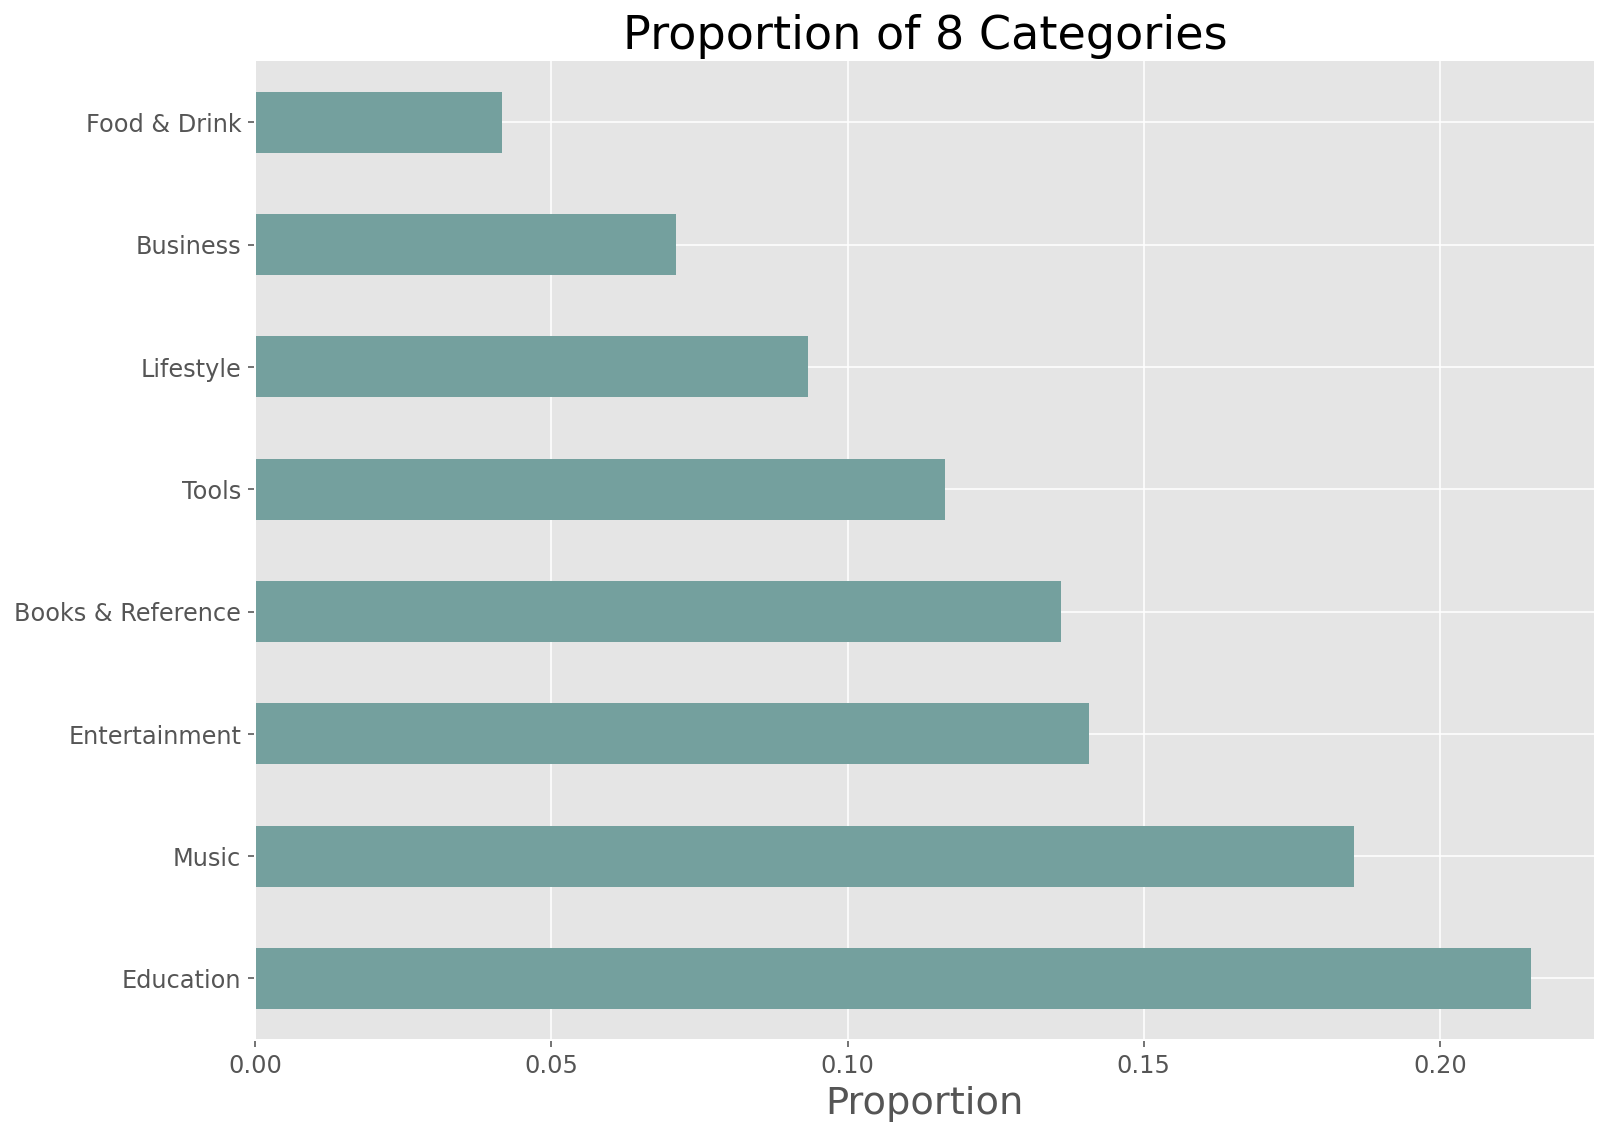

In [ ]:
fig, ax = plt.subplots()

# Plot a normalized countplot
top['category'].value_counts(normalize=True).plot.barh()

# Label
ax.set(title='Proportion of 8 Categories',
       xlabel='Proportion', ylabel='')

plt.show();

Educational apps make up more than one fifth of the data. 

It would be ideal if the `install_count` were given as integers. But they are collapsed into categories which makes it impossible to see their distribution as a numeric feature. We have to plot them in the same way as above:

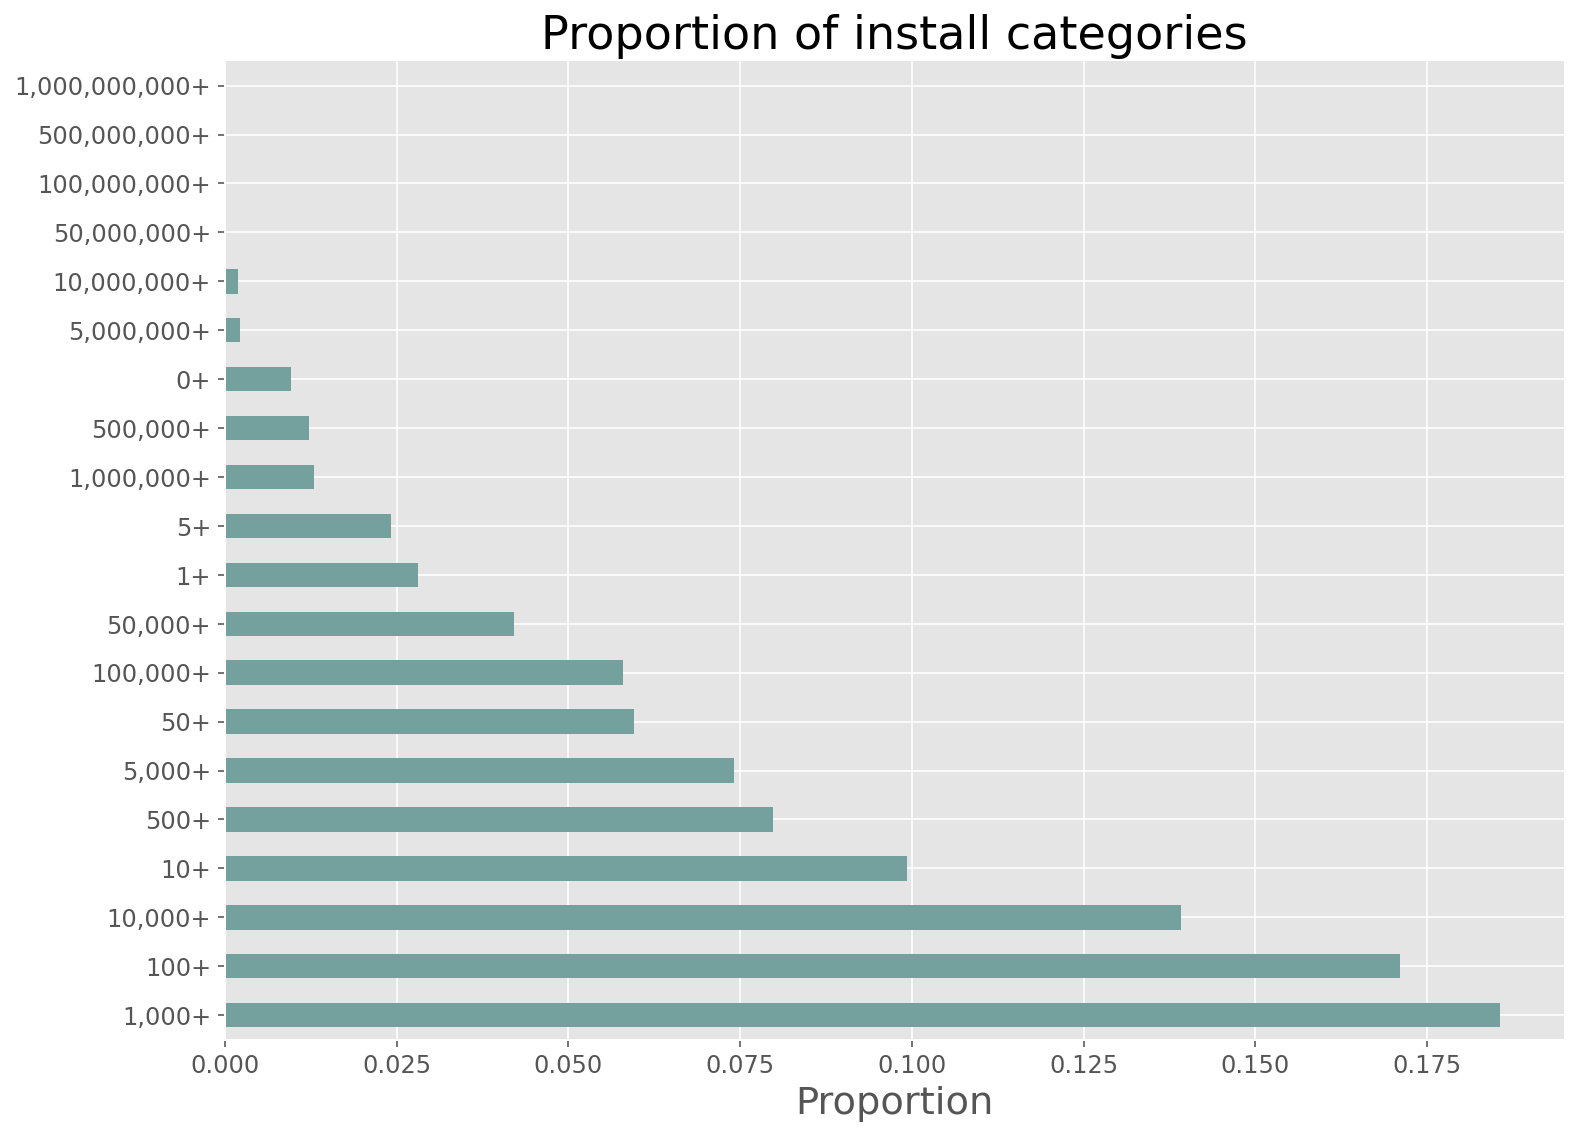

In [ ]:
fig, ax = plt.subplots()

# Create a normalized countplot
top.installs.value_counts(normalize=True).plot.barh()

ax.set(title='Proportion of install categories',
       xlabel='Proportion', ylabel='')

plt.show();

The plot shows that the vast majority of installs are between 10 and 10k installs. We may get better insight if we plotted `rating_count`. The number of ratings is given as exact figures and logically, they are positively related to install count. 



5-number-summary of `rating_count`:

In [ ]:
with pd.option_context('float_format', '{:f}'.format):
    top.rating_count.describe()

count     570129.000000
mean        1304.621249
std        42618.451999
min            0.000000
25%            0.000000
50%            8.000000
75%           59.000000
max     16802391.000000
Name: rating_count, dtype: float64

75% of the distribution is less than 60 while the max is over 1.6 million. 

Plot the apps with ratings <60:

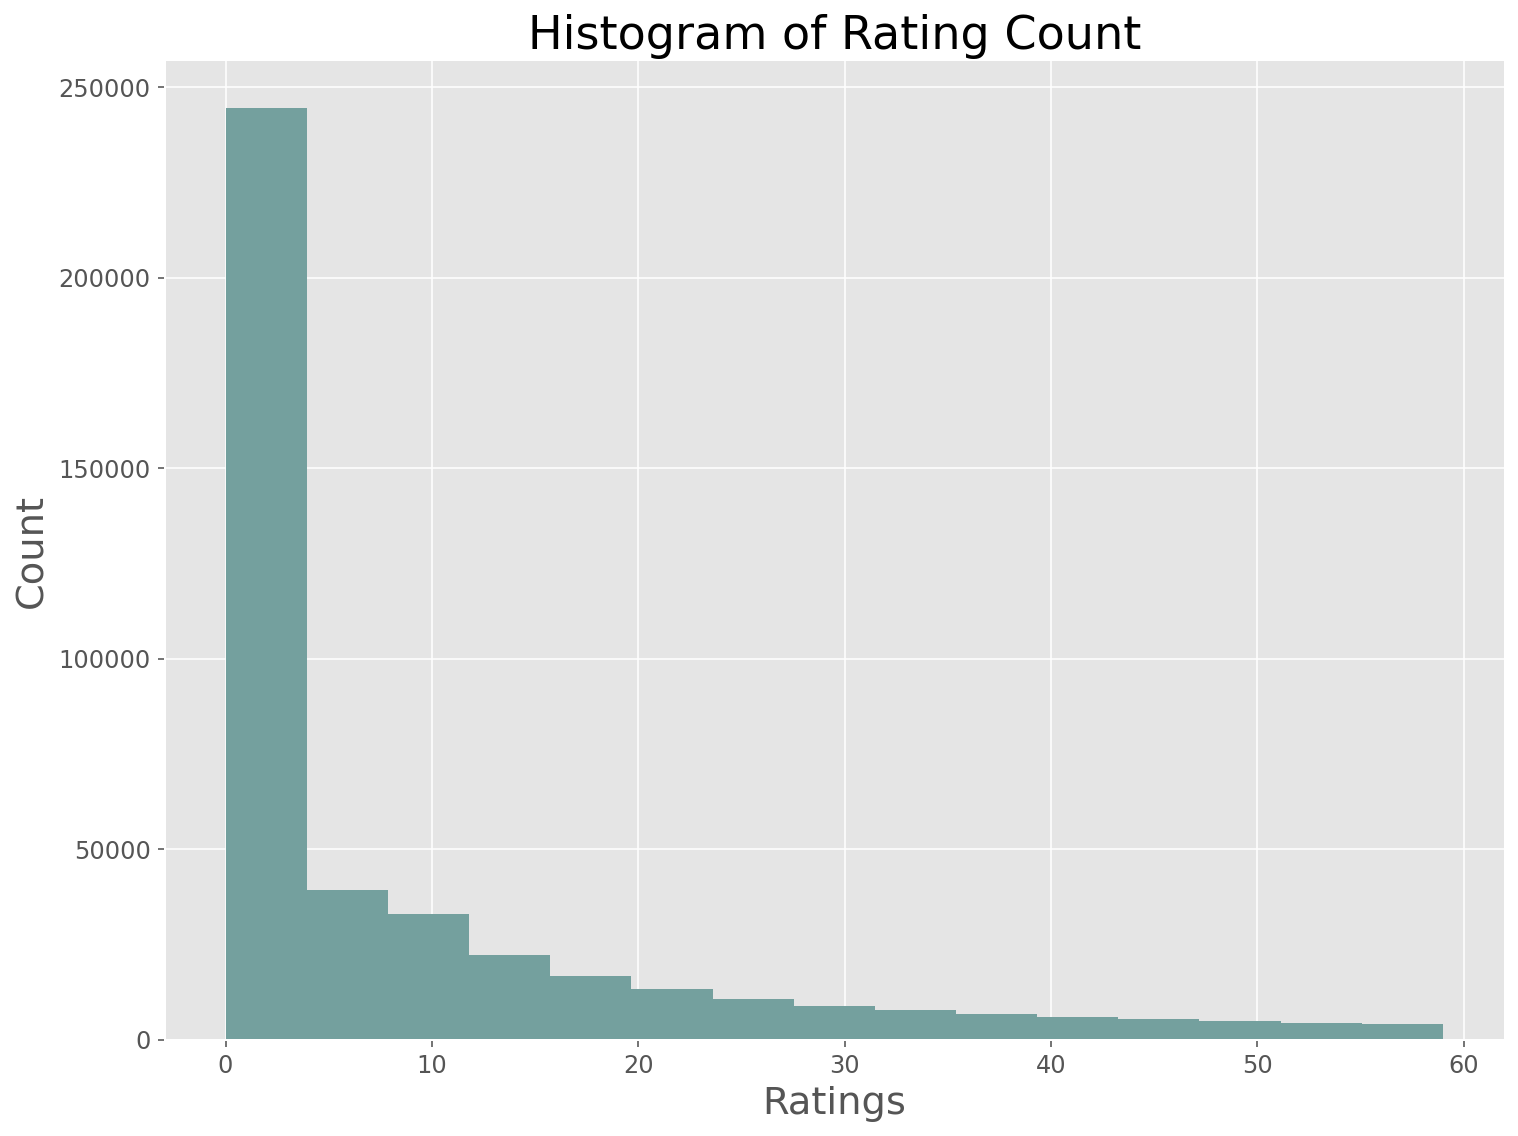

In [ ]:
fig, ax = plt.subplots()

# Choose apps with ratings <60
percentile_75 = top[top['rating_count'] < 60]

ax.hist(percentile_75['rating_count'], bins=15)

ax.set(title='Histogram of Rating Count',
       xlabel='Ratings', ylabel='Count')

plt.show();

This histogram tells us that majority of the apps have no more than 5 ratings. This shows how competetive the mobile market is. Only a small proportion of apps can go as popular as the ones with thousands of ratings.

Apps that have more than 1 million ratings:

In [ ]:
over_mln = top[top['rating_count'] > 1e6]
over_mln.shape

(76, 14)

Out of the initial 1 million apps, only 76 have over 1 million ratings. See which categories have the most number of apps:

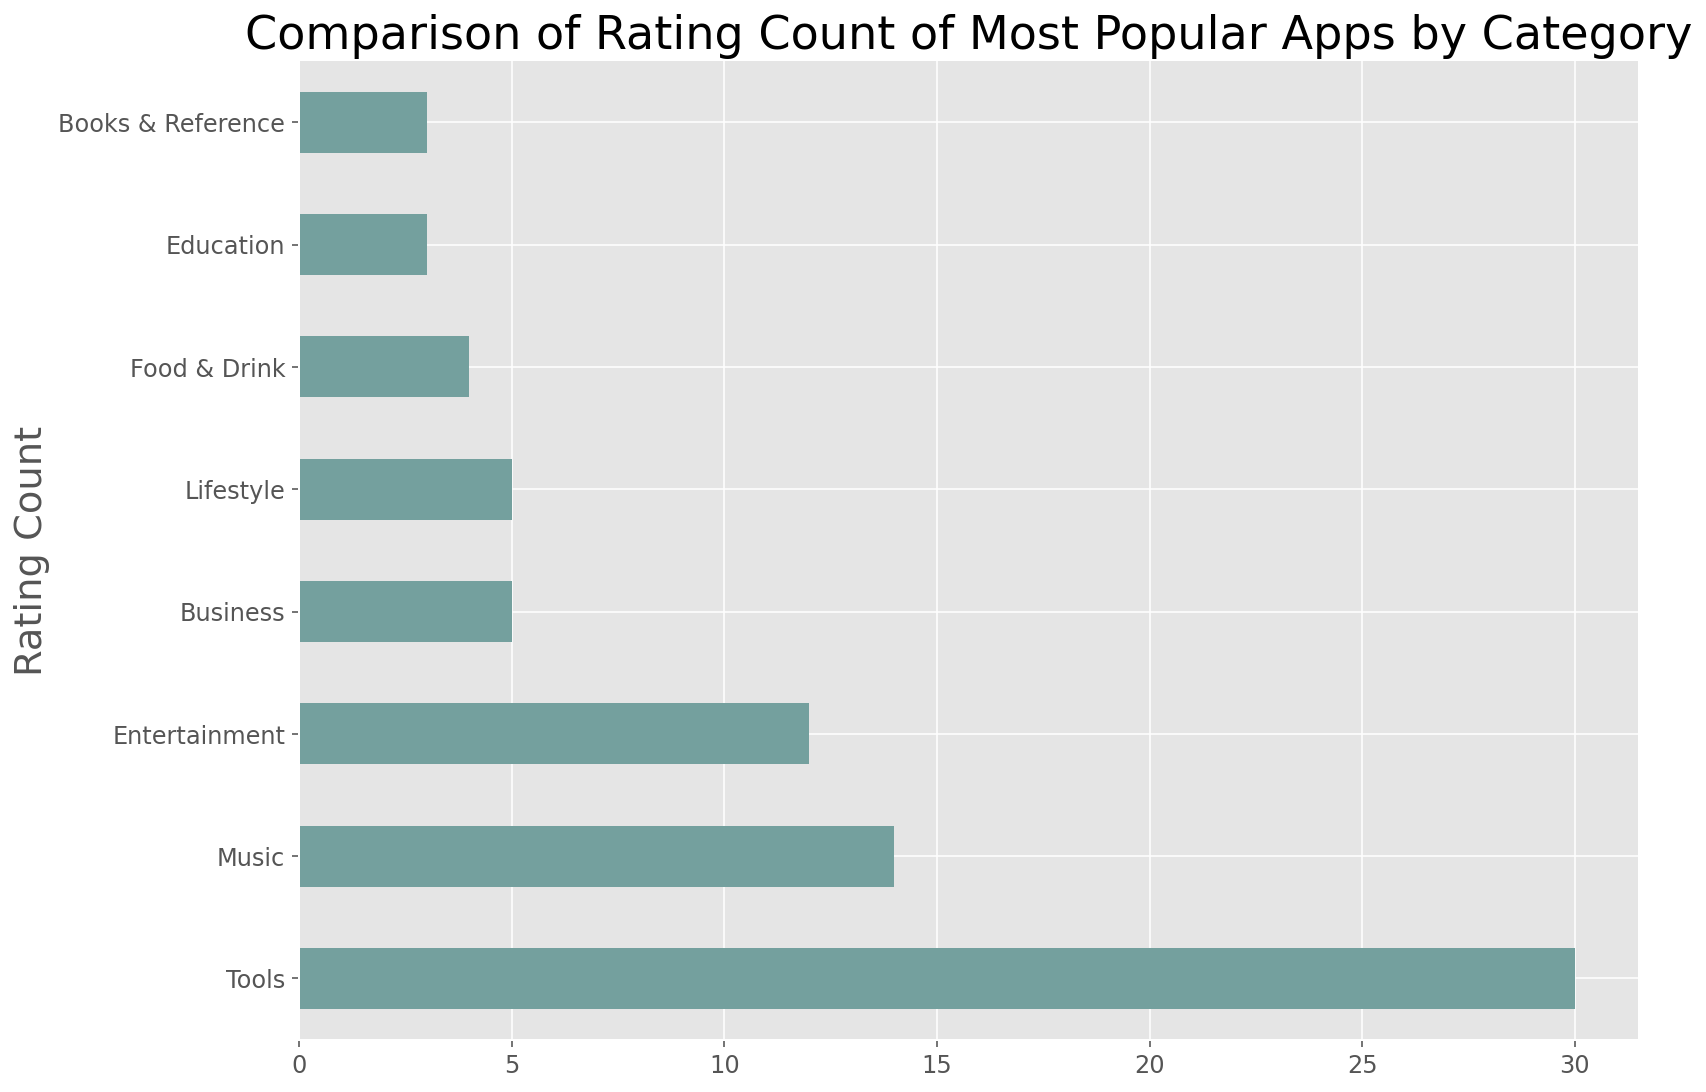

In [ ]:
ax = over_mln.category.value_counts().plot.barh()

ax.set(title='Comparison of Rating Count of Most Popular Apps by Category',
       ylabel='Rating Count')

plt.show();

Not surprisingly, 30 of the apps belong to `Tools` which probably include most popular everyday apps.

5-number summary of the price of paid apps:

In [ ]:
# Create a mask for paid apps
is_paid = top['price'] != 0

with pd.option_context('float_format', '{:f}'.format):
    top[is_paid]['price'].describe()

count   20072.000000
mean        5.421512
std        16.976231
min         0.990000
25%         0.990000
50%         2.490000
75%         4.990000
max       399.990000
Name: price, dtype: float64

`price` contains some serious outliers. Subset for apps that cost less than $10:

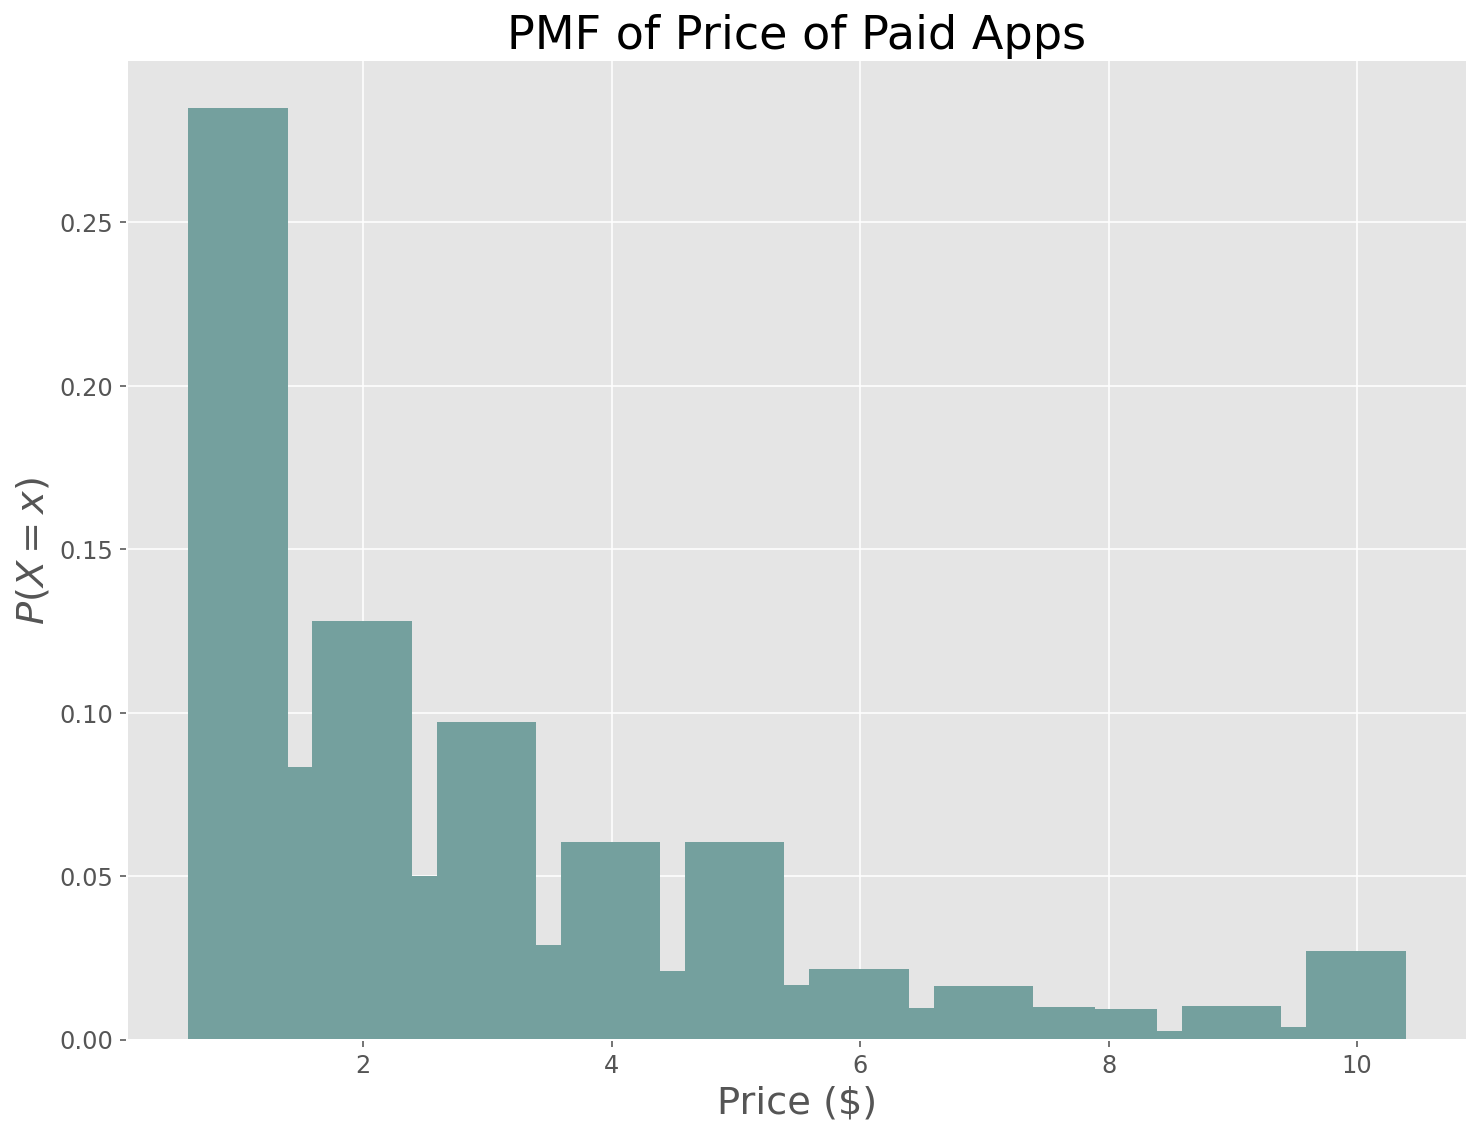

In [ ]:
fig, ax = plt.subplots()

# Subset for apps that cost less than $10
less_10 = top[(top['price'] > 0) & (top['price'] < 10)]

# Create a PMF of price for apps
pmf_price = Pmf.from_seq(less_10['price'])

pmf_price.bar()

ax.set(title='PMF of Price of Paid Apps',
       xlabel='Price ($)', ylabel='$P(X = x)$')

plt.show();

We used a Probability Mass Function to compare the distributions. They avoid binning bias of histograms and allows for improved visual comparison of distributions.

It is clear that most apps cost about a dollar.

# 4. Bivariate Exploration

Comparing the distributions among categories:

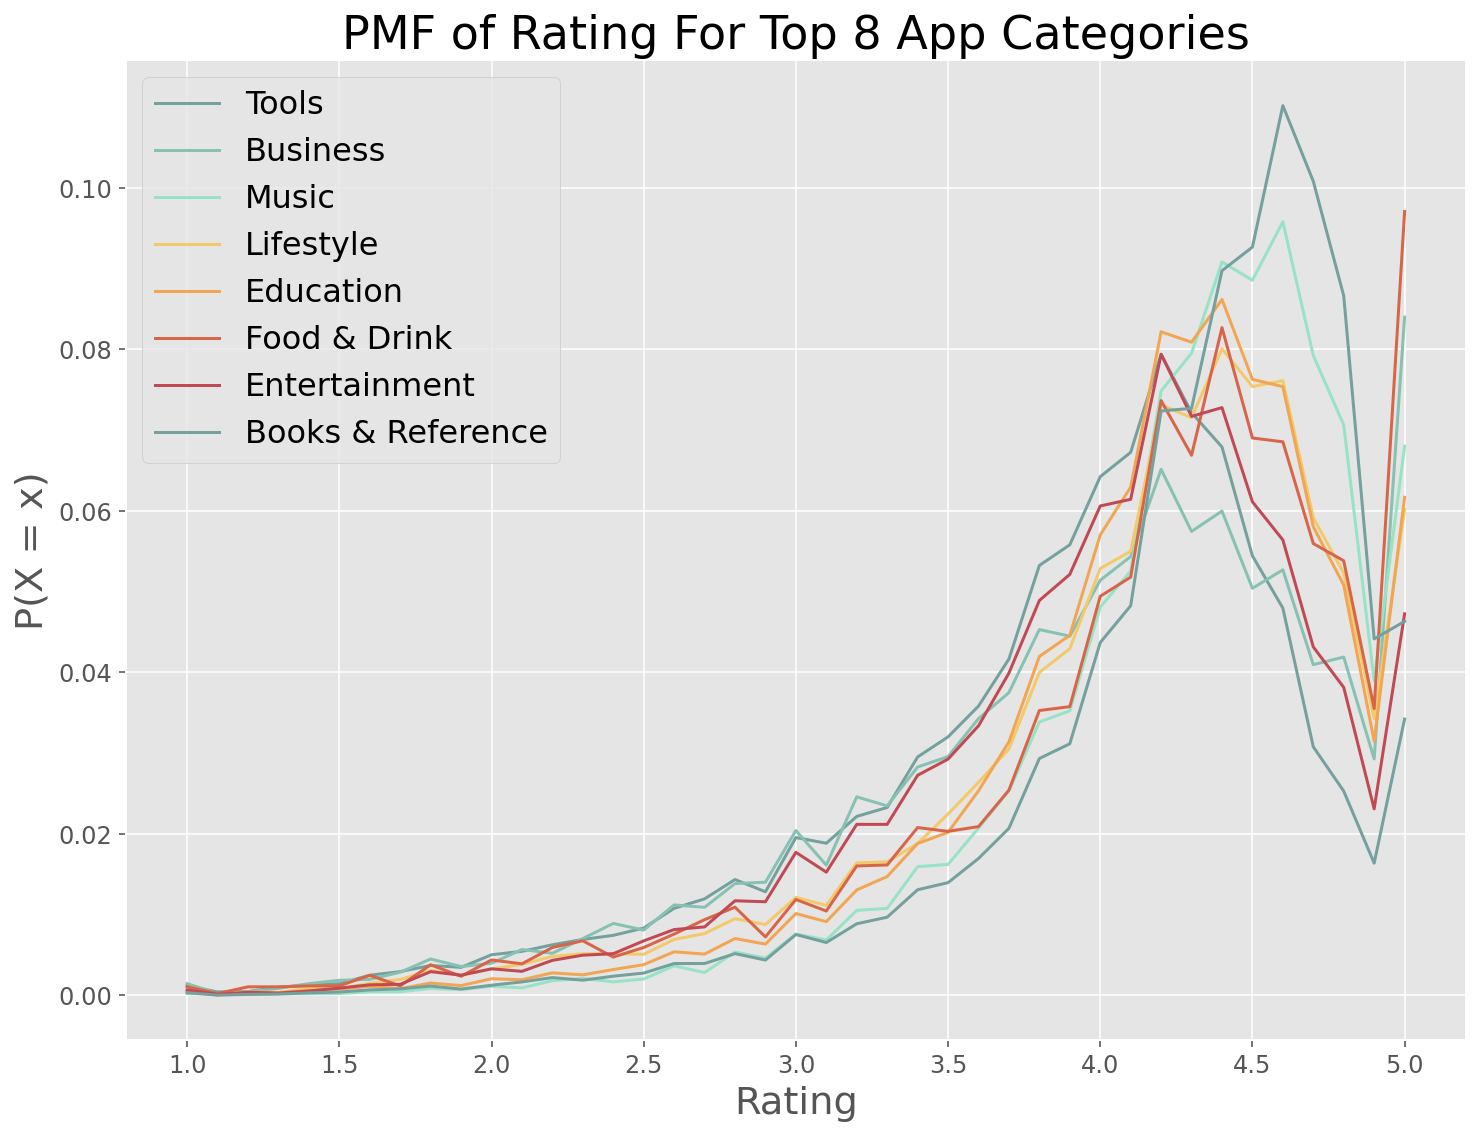

In [ ]:
fig, ax = plt.subplots()
# Extract the unique categories
categories = top['category'].unique()
# Filter out 0-star ratings
over_0 = top[top['rating'] > 0]

for cat in categories:
    pmf_cat = Pmf.from_seq(over_0[over_0['category'] == cat]['rating'])
    ax.plot(pmf_cat, label=cat)

ax.set(title='PMF of Rating For Top 8 App Categories',
       xlabel='Rating',
       ylabel='P(X = x)')

ax.legend()

plt.show();

Probability Mass Function of app ratings show that the distributions of rating for top 8 are pretty similar. However, more apps in Music and Tools seem to be rated ~4.6 compared to other groups.

From this, rating counts and number of installs probably have similar distributions across categories.

Comparing prices of the apps across categories:

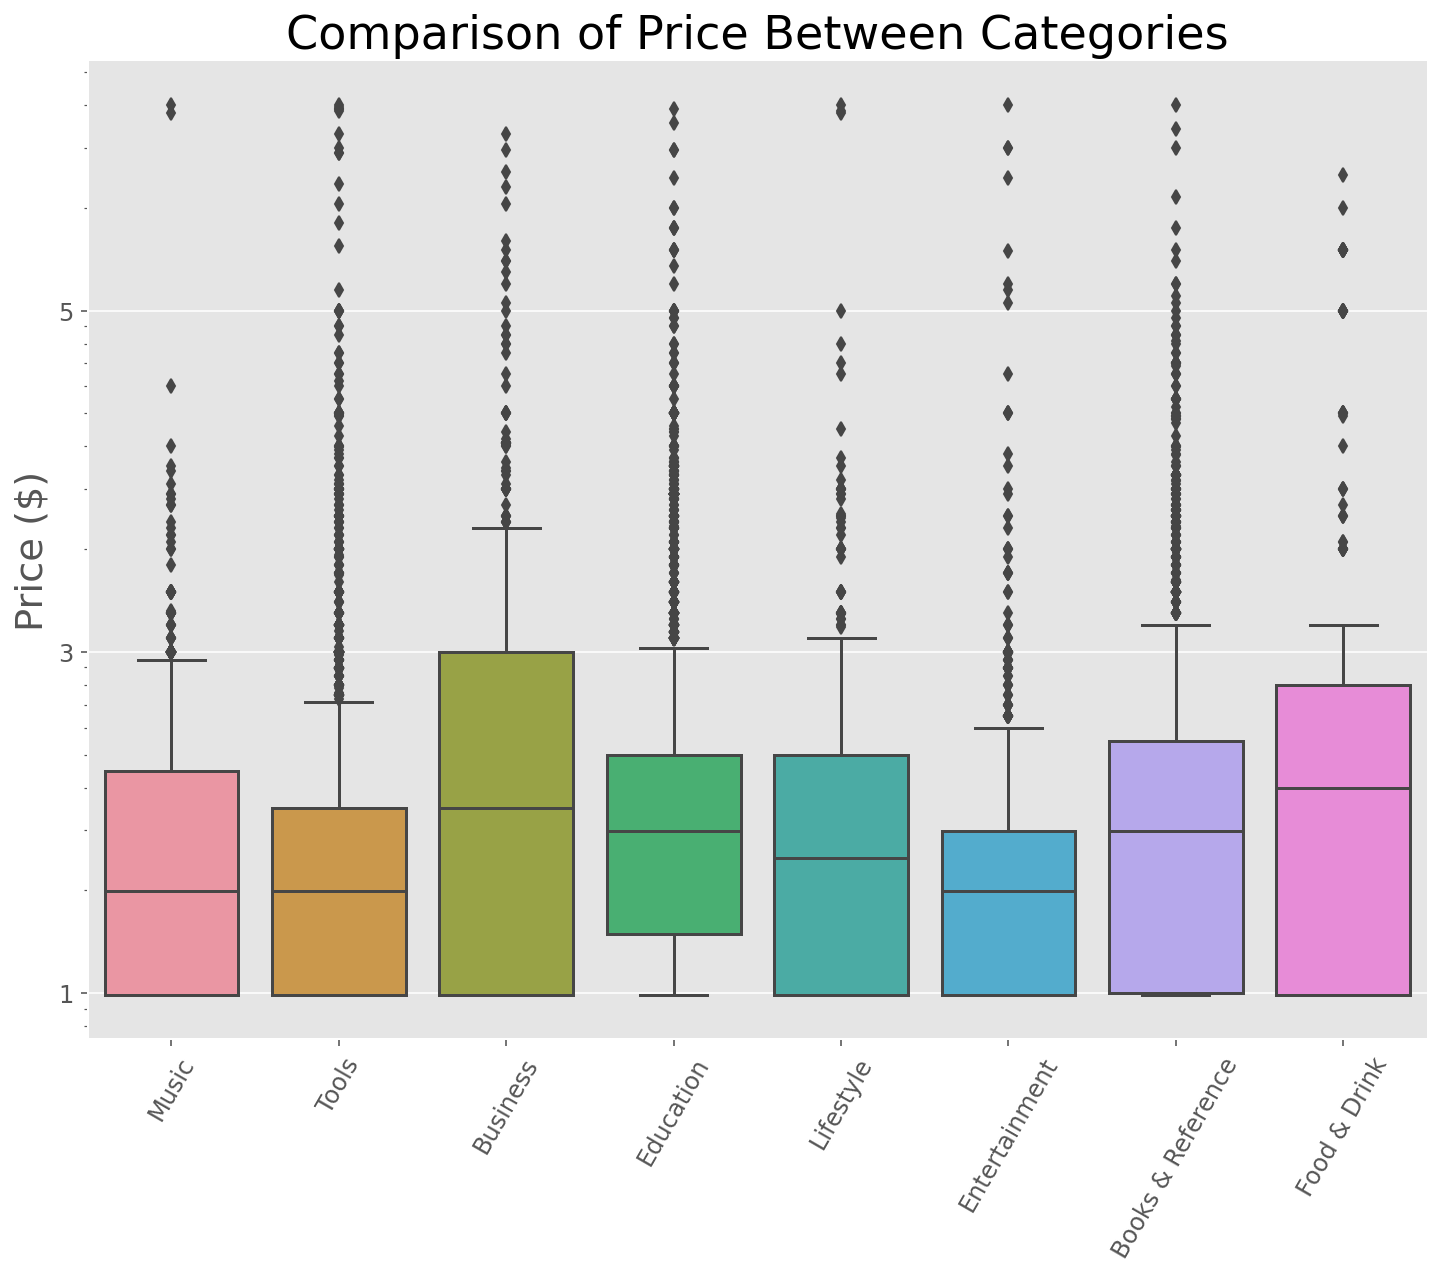

In [ ]:
fig, ax = plt.subplots()

sns.boxplot(x='category', y='price', data=top[is_paid])

ax.set_yscale('log')

ax.set(title='Comparison of Price Between Categories',
       xlabel='', ylabel='Price ($)')

# Rotate xtick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

# Set custom yticklabels
y_ticks = [0.3, 0.5, 1, 3, 5, 10, 30, 100, 300]
ax.set_yticklabels(y_ticks)

plt.show();

Looking at median price for each, `Food & Drink` seems to be top and `Business` is a close second.

See if more ratings mean higher ratings (only look at apps with ratings fewer than 100k and exclude the ones with no ratings):

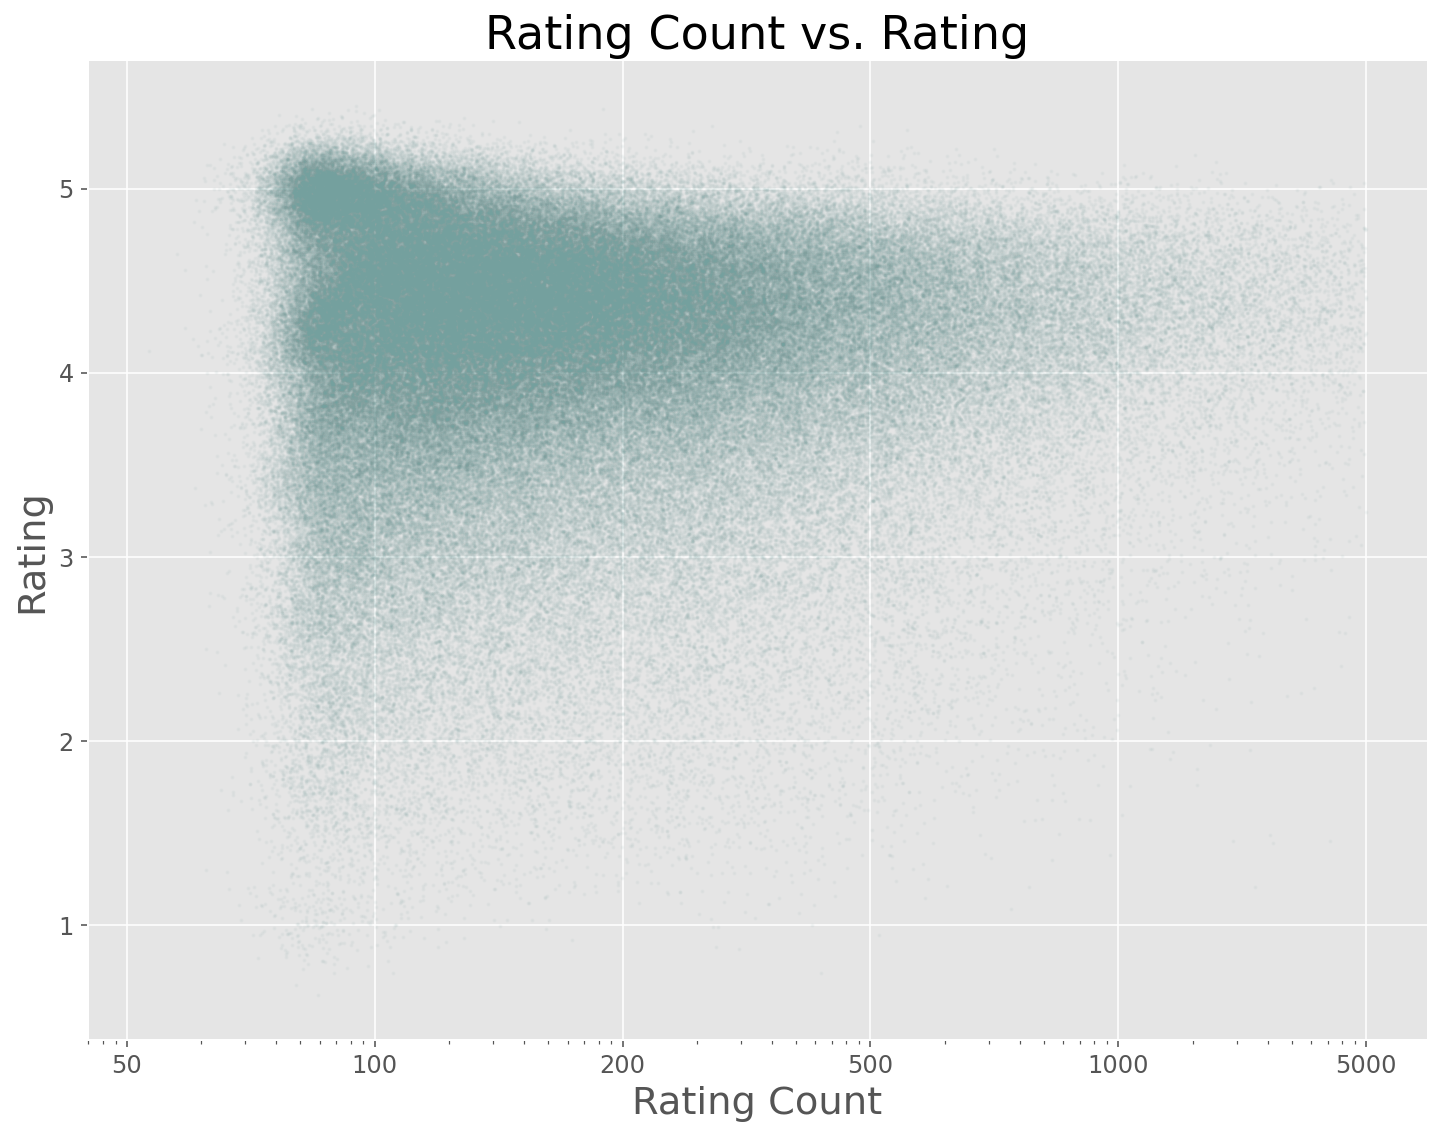

In [ ]:
fig, ax = plt.subplots()

# Filter out undesired apps
majority_rated = top[(top['rating_count'] > 0) & (top['rating_count'] < 1e5)]

# Jitter the ratings
rating_jittered = majority_rated['rating'] + np.random.normal(0, 0.12, len(majority_rated))
# Jitter the number of ratings
count_jittered = majority_rated['rating_count'] + np.random.normal(0, 1, len(majority_rated))

ax.plot(count_jittered, rating_jittered, 
        marker='o', linestyle='none', markersize=1, alpha=0.05)

# Use log scale
ax.set_xscale('log')
# Set custom tick labels
x_tick_labels = [1, 10, 50, 100, 200, 500, 1000, 5000, 10000, 50000, 100000]
ax.set_xticklabels(x_tick_labels)

# Label
ax.set(title='Rating Count vs. Rating',
       xlabel='Rating Count', 
       ylabel='Rating')

plt.show();

Even though there are much more apps with few but high ratings, there seems to be a weak positive non-linear relationship between rating count and rating.

Check this by plotting a correlation matrix:

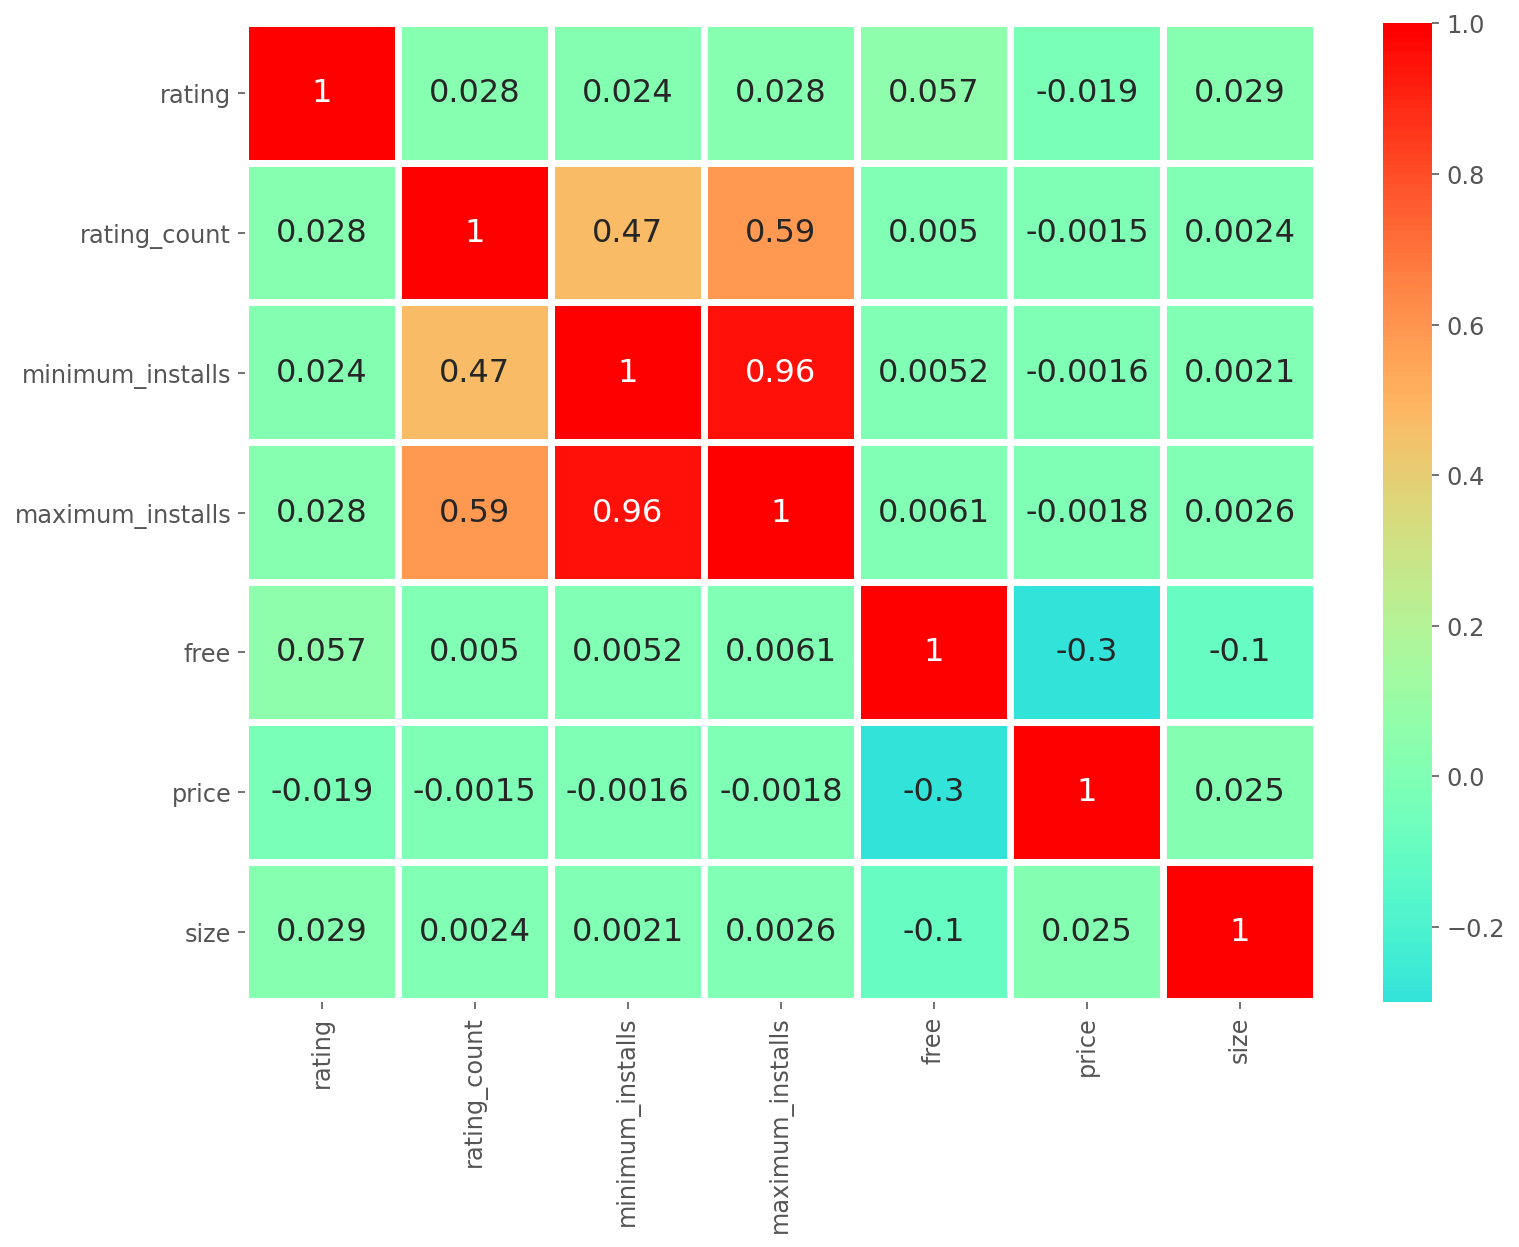

In [ ]:
sns.heatmap(top.corr(), annot=True, 
            linewidths=3, center=0, cmap='rainbow');

Note that rating and rating count has a coefficient of $r=0.028$. 

Look at content rating of the apps and grouping them into paid and free categories:

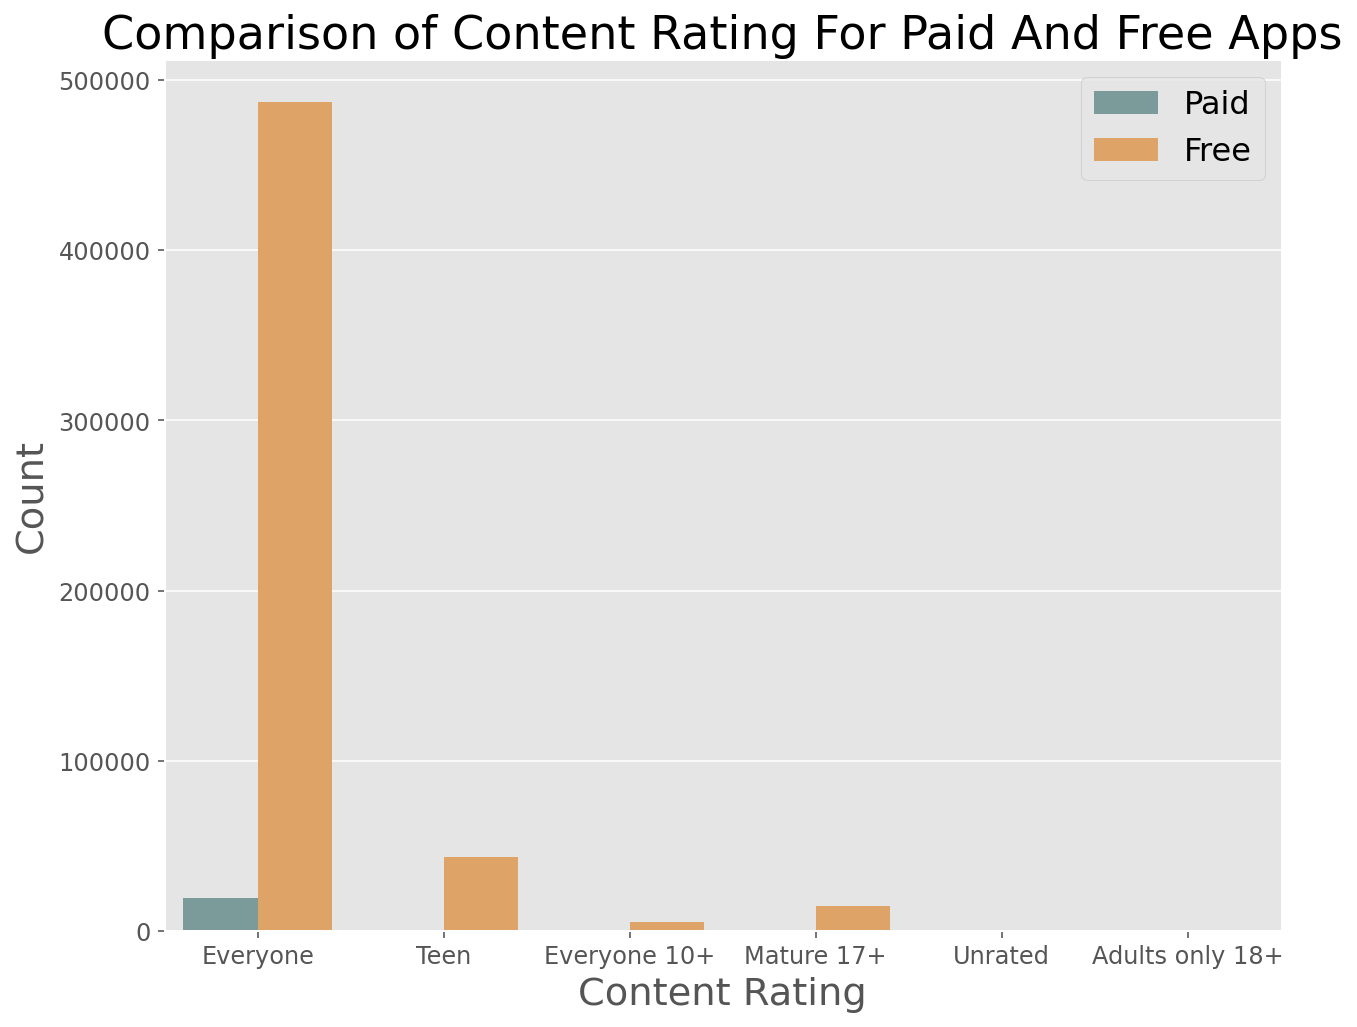

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.countplot(x='content_rating', hue='free', data=top,
              palette=['#74a09e','#f2a553'])

ax.legend(['Paid', 'Free'], loc='upper right')

ax.set(title='Comparison of Content Rating For Paid And Free Apps',
       xlabel='Content Rating', ylabel='Count')

plt.show();

The countplot shows that the vast majority is rated for `Everyone`. 

# 5. Multivariate Exploration

Minimum and maximum installs columns show the estimated minimum and maximum installs.

Taking the mean of the two columns can be better estimate for the true install count:

In [ ]:
top['true_installs'] = (top['minimum_installs'] + top['maximum_installs']) // 2

See if there is a relationship between rating and install count + group the plots into paid and free apps:

In [ ]:
top['free'] = top['free'].replace({True: 'Free', False: 'Paid'})

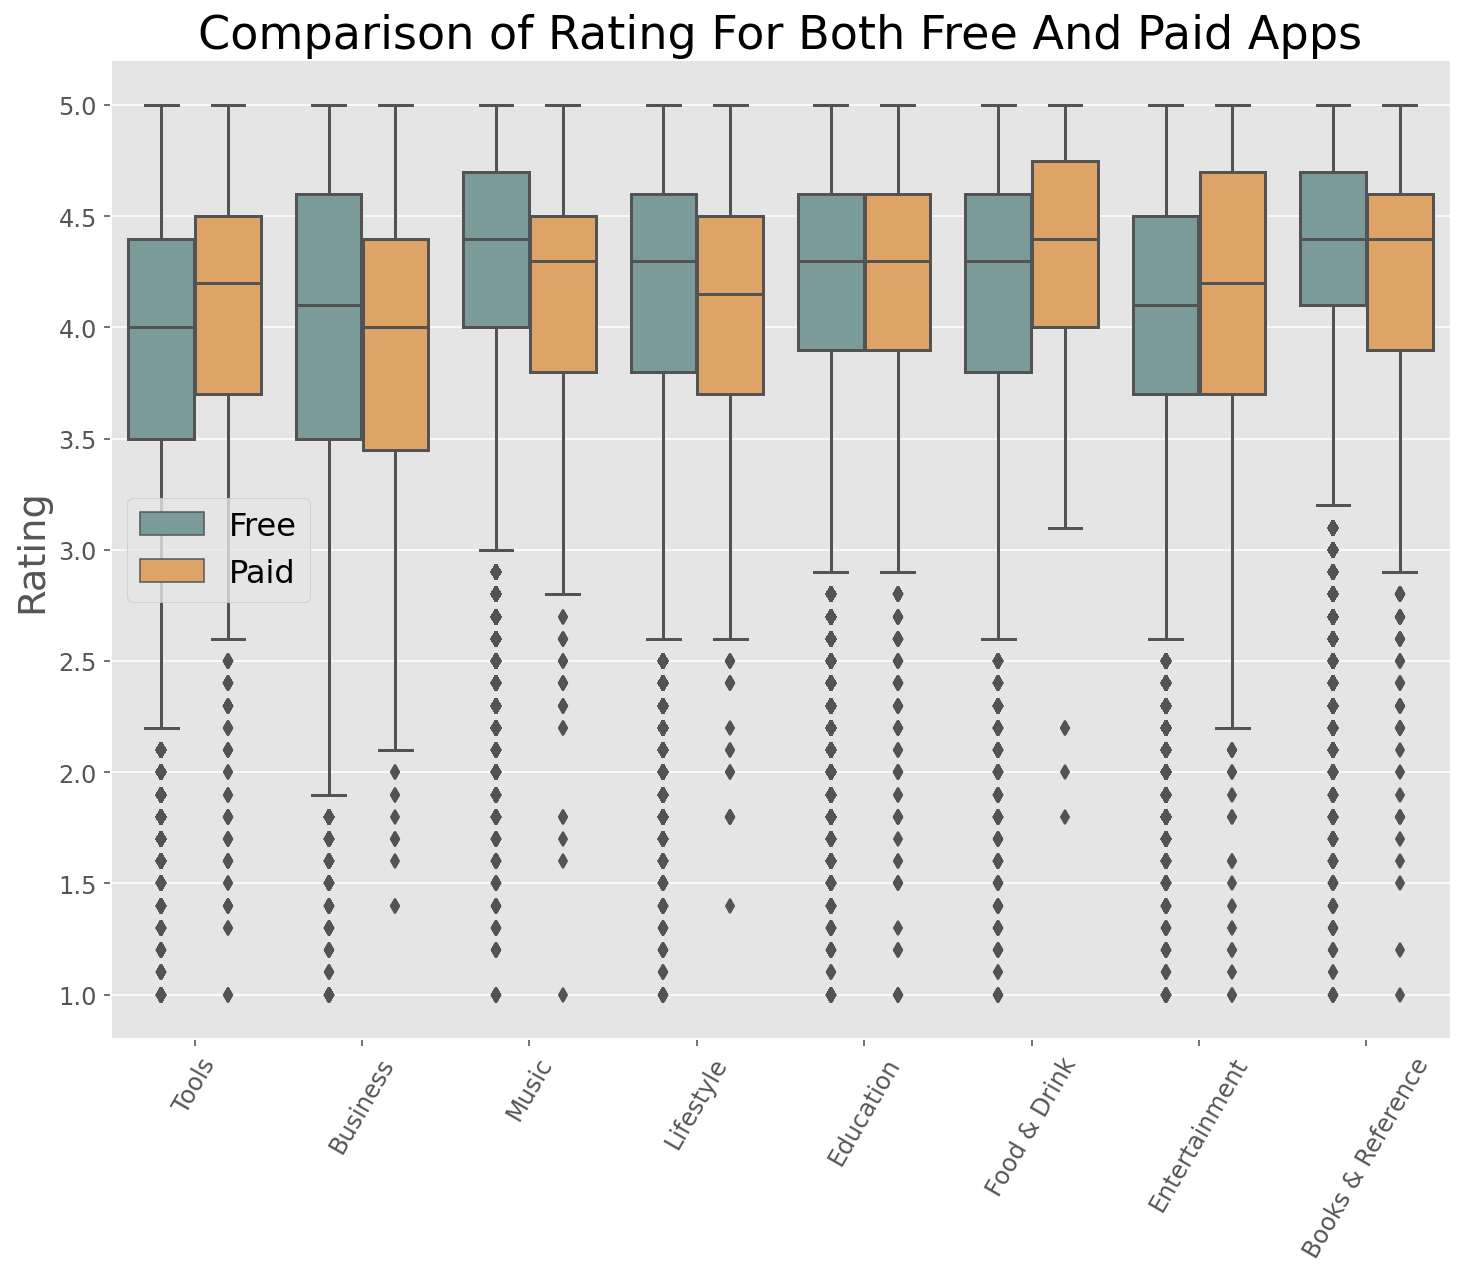

In [ ]:
fig, ax = plt.subplots()

# Create a boxplot
sns.boxplot(x='category', y='rating', hue='free', data=top[top['rating'] > 0],
           palette=['#74a09e','#f2a553'])

# Labelling
ax.set(title='Comparison of Rating For Both Free And Paid Apps',
       xlabel='', ylabel='Rating')

# Rotate xticks
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

ax.legend(title='')

plt.show();

Education and Books categories have the same median rating. Tools and Business apps are generally lower rated than other categories. 

Seems like whether app is free or paid does not have clear effect on its rating. 

See if well-maintainted apps have higher ratings by looking at the `last_updated` column and compare it to the date of the latest version of this dataset, which was December, 2020.

First, find out how many days have passed since an app was last updated:

In [ ]:
# Covert last_updated to datetime
top['last_updated'] = pd.to_datetime(top['last_updated'], format='%b %d, %Y',
                                 infer_datetime_format=True)

In [ ]:
top['days_elapsed'] = (datetime.datetime(2020, 12, 31) - top['last_updated']).dt.days

5-number summary of `days_elapsed`:

In [ ]:
top.days_elapsed.describe()

count    570129.000000
mean        499.277641
std         532.959011
min          28.000000
25%         118.000000
50%         309.000000
75%         689.000000
max        4004.000000
Name: days_elapsed, dtype: float64

Most apps were updated within a year at the time of collecting this dataset. 

Plot it against `rating` grouping by `Free` or `Paid` (exclude apps with no rating):

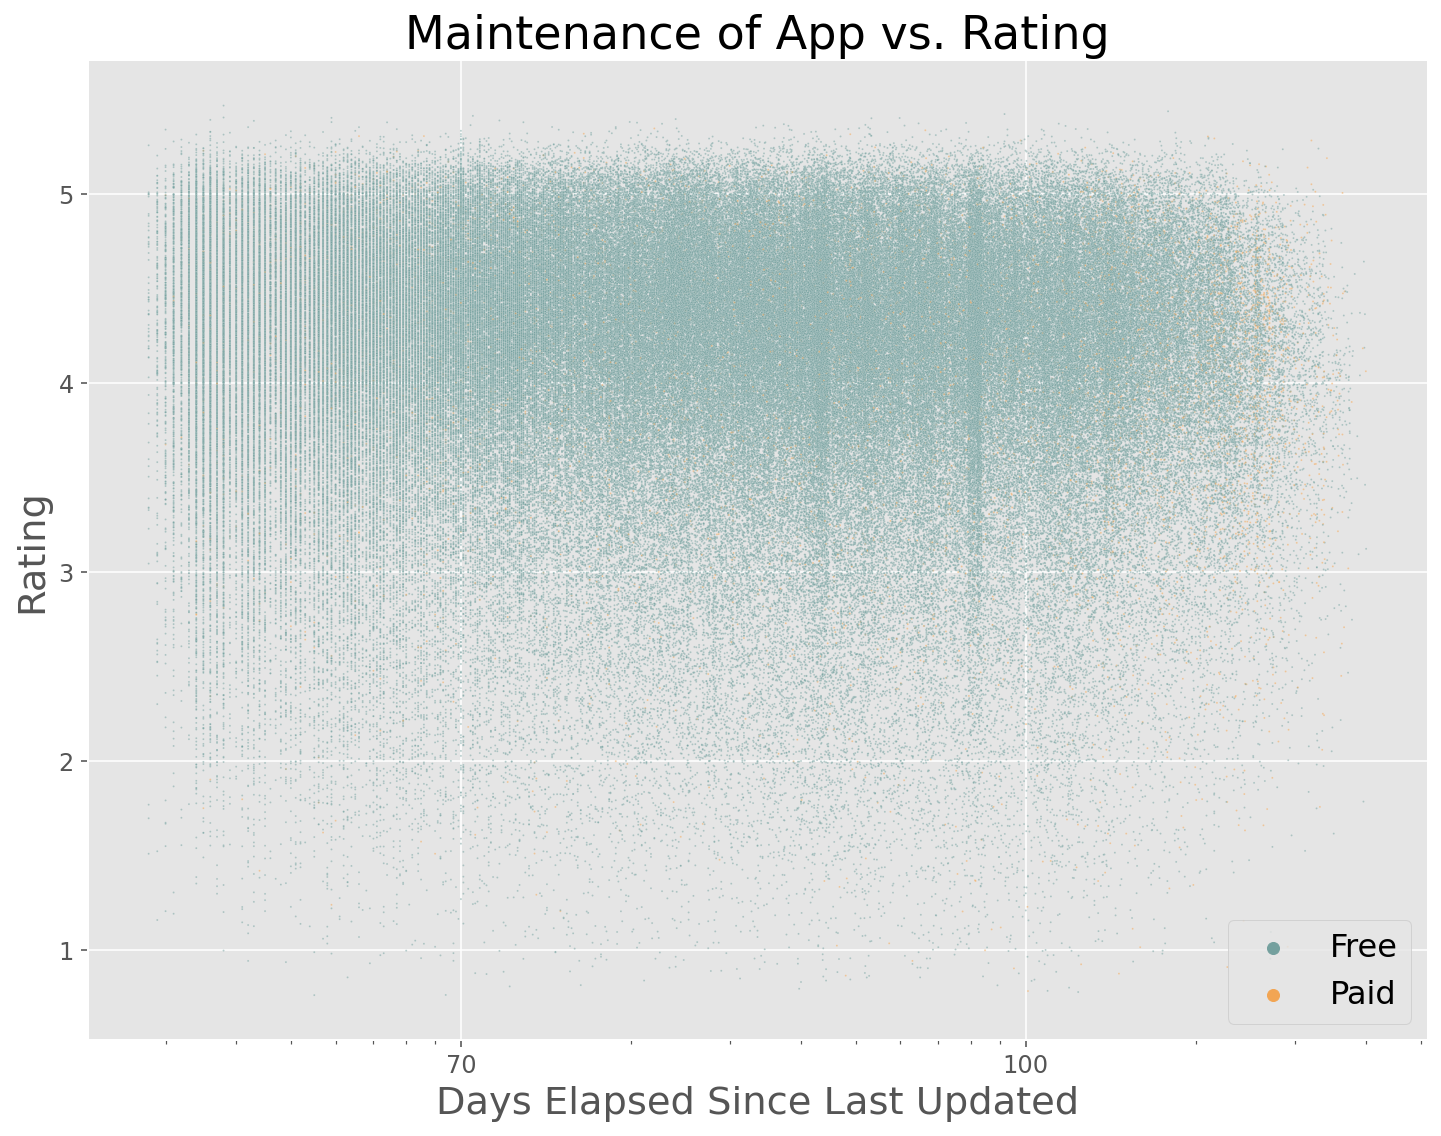

In [ ]:
fig, ax = plt.subplots()

with_rating = top[top['rating'] > 0]

# Jitter the ratings for a nicer visual
with_rating['rating_jittered'] = with_rating['rating'] + np.random.normal(0, 0.12, len(with_rating))
sns.scatterplot(x='days_elapsed', y='rating_jittered', hue='free', data=with_rating,
                alpha=0.5, s=1, palette=['#74a09e','#f2a553'])

ax.set(title='Maintenance of App vs. Rating', xlabel='Days Elapsed Since Last Updated',
       ylabel='Rating')

ax.set_xscale('log')
ax.set_xticklabels([10, 30, 70, 100, 300, 700, 1000])
ax.legend(title='')
plt.show();

It seems maintenance didn't have any effect on rating. But there is a possibility that not all apps were updated with relevant information by the dataset owner.

Distribution grouped by category:

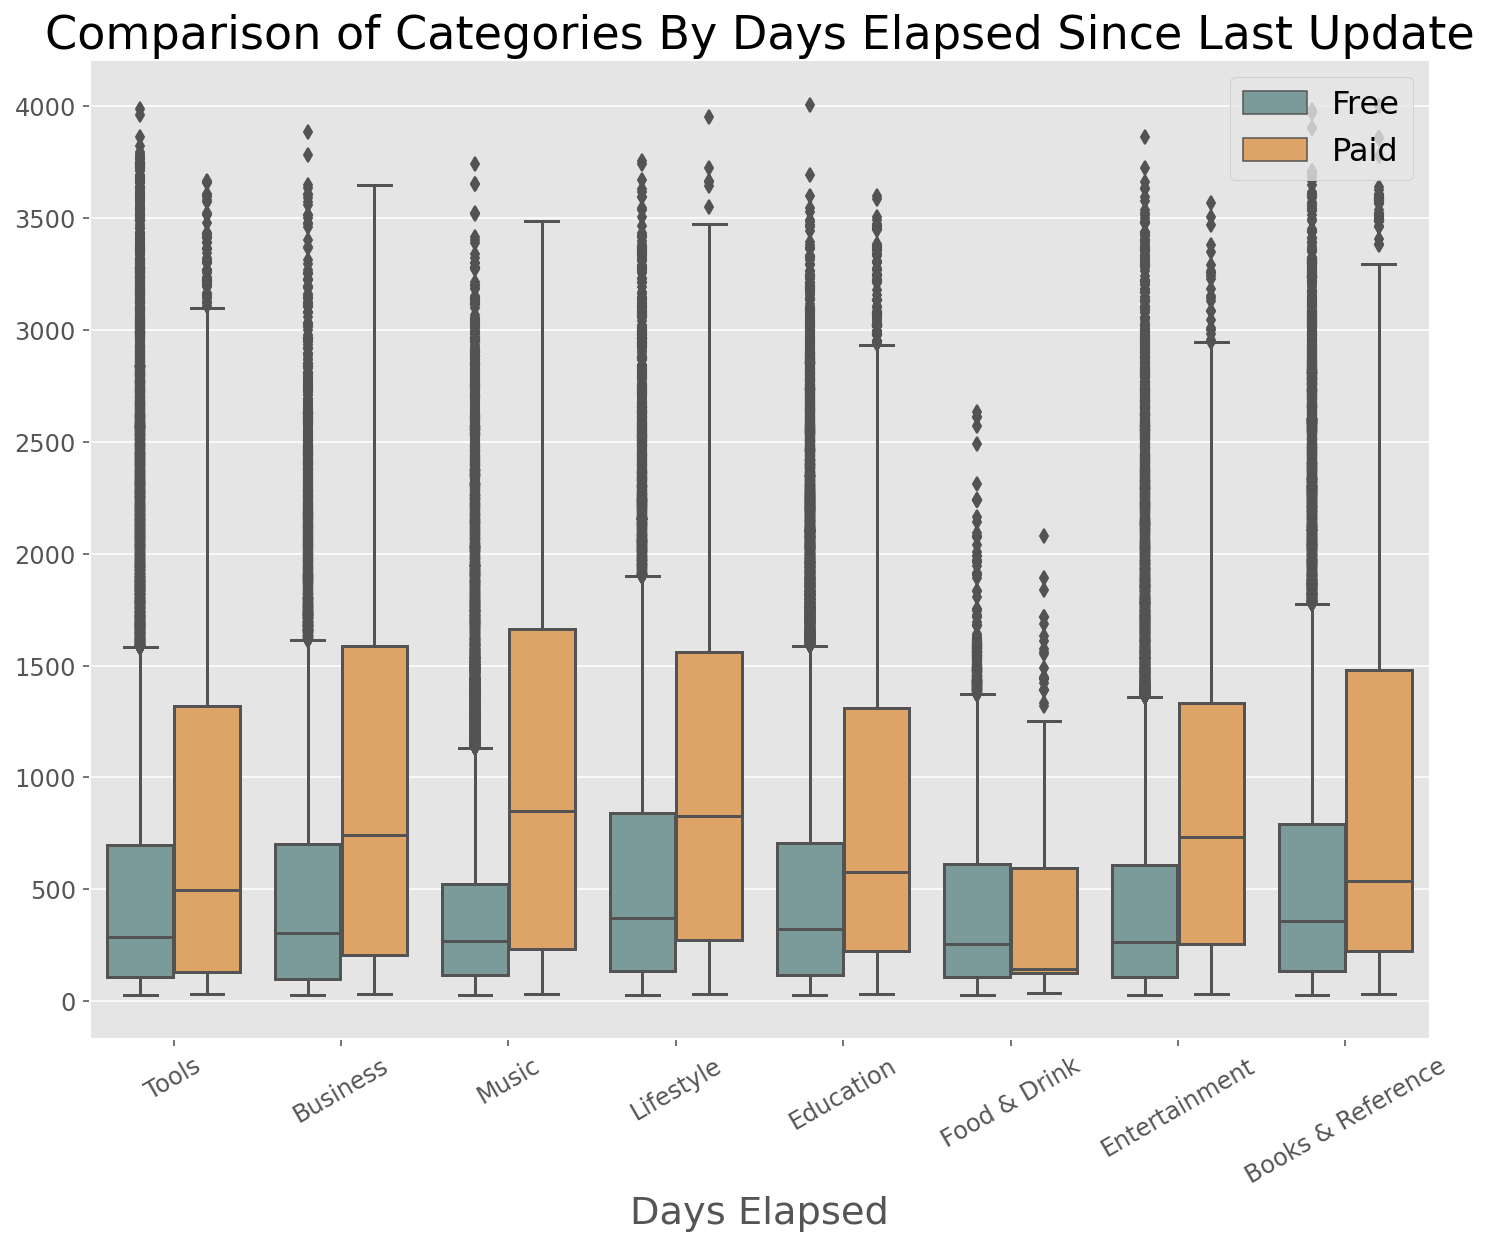

In [ ]:
ax = sns.boxplot(x='category', y='days_elapsed', data=top, 
                 hue='free', palette=['#74a09e','#f2a553'])

ax.set(title='Comparison of Categories By Days Elapsed Since Last Update', 
       xlabel='Days Elapsed', ylabel='')

ax.legend(loc='upper right', title='')

ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

plt.show();

The above plot shows a clear trend. Surprisingly, paid apps are much less maintained than free apps except for Food & Drink category. 

# 6. Brief Summary of EDA

This dataset showed how competetive the Google Play Store is. More than half of the apps had close to 0 ratings and installs. 

Even though there were more than 50 categories, only top 8 were explored which accounted to more than half of all apps. Among the top 8, `Tools` category was a clear winner in terms of install and rating count. 

Majority of the paid apps cost around a dollar however there were outliers as huge as 400 dollars. 
For paid apps, most expensive categories were Food & Drink and Business. 

In 4th and 5th parts of the exploration, the dataset was looked at from different angles. Specifically, the relationships between rating and rating count, rating and install count, rating and maintenance were explored. 

For better insight, apps with no ratings and installs were exlcuded. This showed that most apps had a rating of ~4.5 and most highly-rated apps were in Music.

Reference: Majority of this notebook was customized from [Bex T, My 6-part Powerful EDA Template That Speaks of Ultimate Skill](https://towardsdatascience.com/my-6-part-powerful-eda-template-that-speaks-of-ultimate-skill-6bdde3c91431)